# Problem definiton
**Segmentation of gliomas in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
* Anything else -> pixel is not on a tumor region (0)

The sub-regions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT)
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else.



![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

# Setup env

In [17]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
#import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [18]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 50
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



Text(0.5, 1.0, 'Mask')

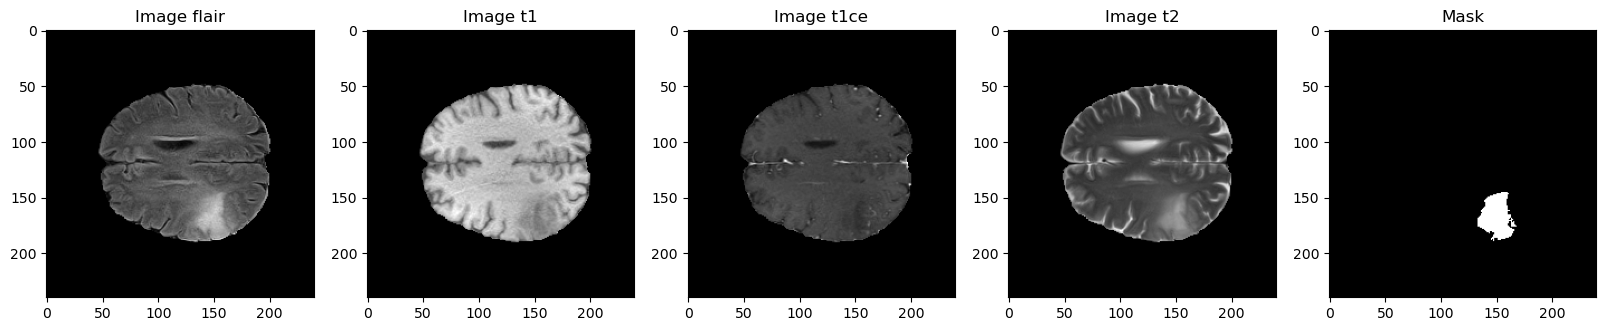

In [20]:
TRAIN_DATASET_PATH = 'D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'D:/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_011/BraTS20_Training_011_flair.nii').get_fdata() #flair
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_011/BraTS20_Training_011_t1.nii').get_fdata() #t1
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_011/BraTS20_Training_011_t1ce.nii').get_fdata() #t1ce
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_011/BraTS20_Training_011_t2.nii').get_fdata() #t2
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_011/BraTS20_Training_011_seg.nii').get_fdata() #seg


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w], cmap = 'gray')
ax5.set_title('Mask')


**Show whole nifti data -> print each slice from 3d data**

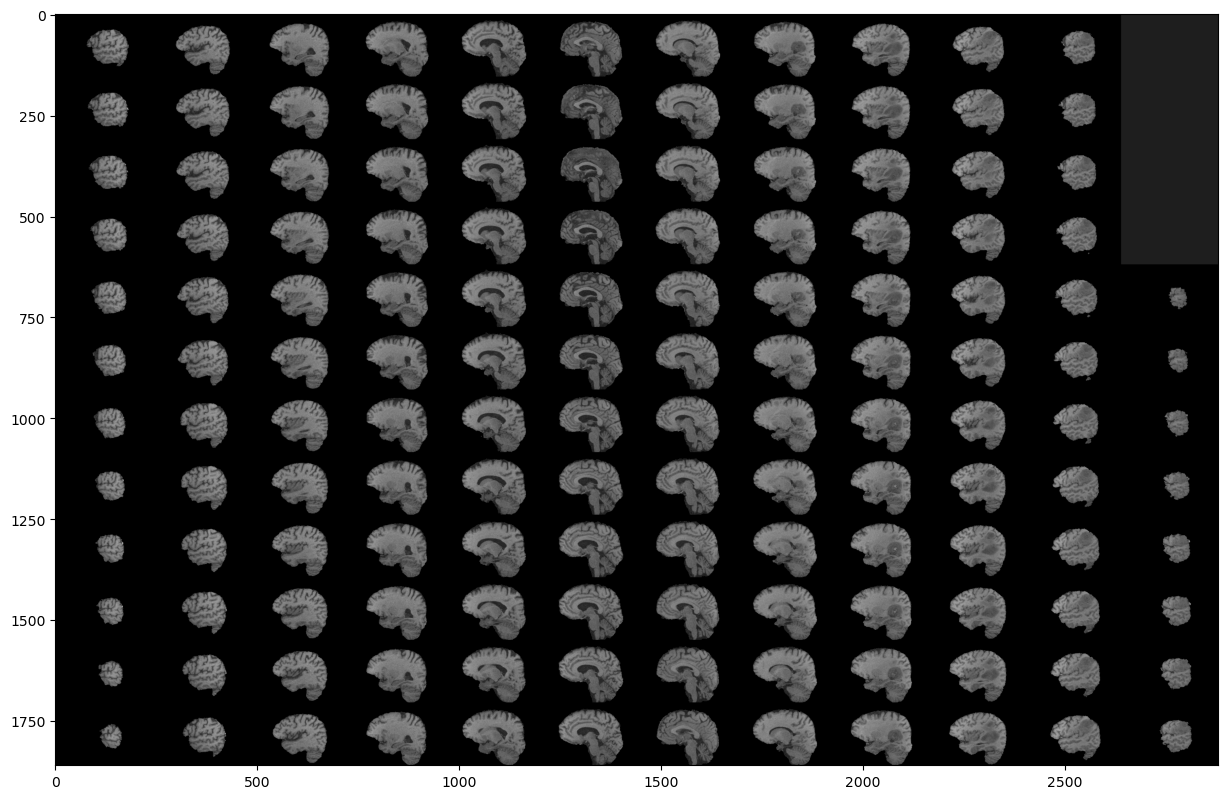

In [22]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

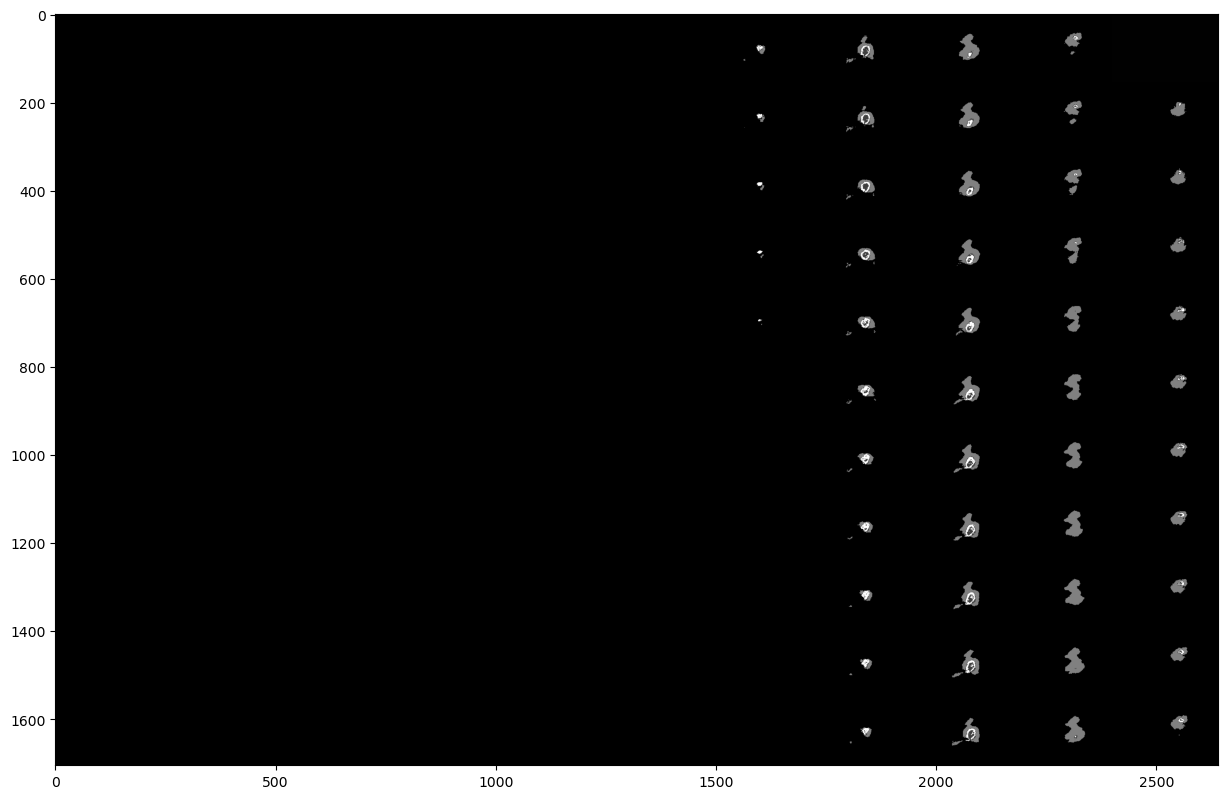

In [24]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [25]:
#shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
#gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

**Gif representation of slices in 3D volume**
<img src="https://media1.tenor.com/images/15427ffc1399afc3334f12fd27549a95/tenor.gif?itemid=20554734">

**Show segments of tumor using different effects**

# Create model || U-Net: Convolutional Networks for Biomedical Image Segmentation
he u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin
[more on](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
![official definiton](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


# Loss function
**Dice coefficient**
, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

![dice loss](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

**As matrices**
![dice loss](https://www.jeremyjordan.me/content/images/2018/05/intersection-1.png)

[Implementation, (images above) and explanation can be found here](https://www.jeremyjordan.me/semantic-segmentation/)

In [31]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [32]:
IMG_SIZE=128

In [33]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
# model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


**model architecture** <br>
If you are about to use U-NET, I suggest to check out this awesome library that I found later, after manual implementation of U-NET [keras-unet-collection](https://pypi.org/project/keras-unet-collection/), which also contains implementation of dice loss, tversky loss and many more!

In [35]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [37]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_021')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


**Override Keras sequence DataGenerator class**

In [39]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids, batch_size=4)
valid_generator = DataGenerator(val_ids, batch_size=4)
test_generator = DataGenerator(test_ids, batch_size=4)

**Number of data used**
for training / testing / validation

C:\Users\Admin\AppData\Local\Temp\ipykernel_13768\1596146384.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


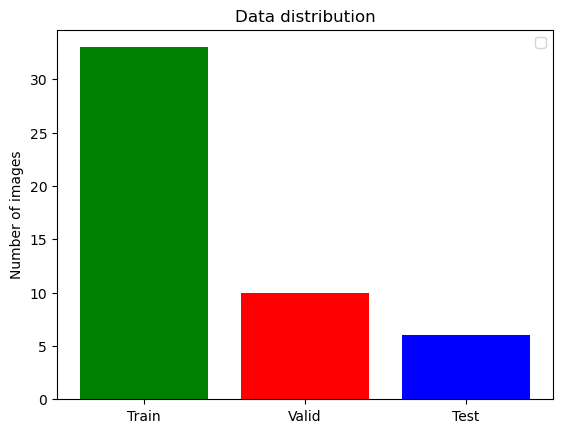

In [41]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

**Add callback for training process**

In [43]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
        csv_logger
    ]

# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again

In [45]:
# for X, y in training_generator:
#     print("X shape:", X.shape, "y shape:", y.shape)
#     break


In [47]:
K.clear_session()
from tensorflow.keras import backend as K
# history =  model.fit(training_generator,
#                     epochs=2,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  
# model.save("model_x1_1.h5")

**Visualize the training process**

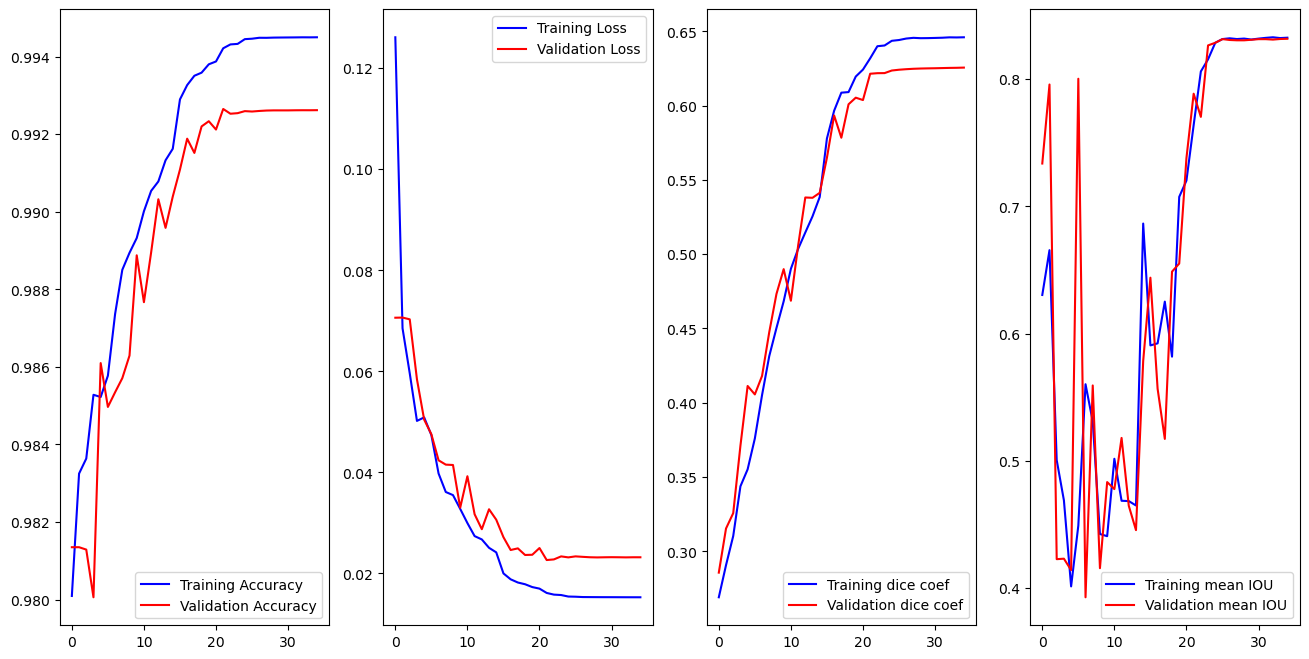

In [53]:
############ load trained model ################
model = keras.models.load_model('D:/archive/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('D:/archive/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [ ]:
# train_dice = hist['dice_coef']  # Assuming 'dice_coef' column exists
# val_dice = hist['val_dice_coef']  # Assuming 'val_dice_coef' column exists
# if 'train_dice' in hist.columns:
#     train_dice = hist['train_dice']
# else:
#     train_dice = np.zeros_like(acc)  # If missing, set it to zero (or a default)

# if 'val_train_dice' in hist.columns:
#     val_dice = hist['val_train_dice']
# else:
#     val_dice = np.zeros_like(val_acc)  # If missing, set it to zero (or a default)
# f, ax = plt.subplots(1, 4, figsize=(16, 8))

# ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
# ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
# ax[0].legend()

# ax[1].plot(epoch, loss, 'b', label='Training Loss')
# ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
# ax[1].legend()

# if 'train_dice' in hist.columns:
#     ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff')
#     ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff')
#     ax[2].legend()
# else:
#     ax[2].plot(epoch, np.zeros_like(epoch), 'b', label='No Dice Coeff')
#     ax[2].legend()

# ax[3].plot(epoch, hist.get('mean_io_u', np.zeros_like(epoch)), 'b', label='Training Mean IoU')
# ax[3].plot(epoch, hist.get('val_mean_io_u', np.zeros_like(epoch)), 'r', label='Validation Mean IoU')
# ax[3].legend()

# plt.show()


# Prediction examples 

In [55]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [56]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
   
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

Flair file path: C:/Users/Admin/Downloads/Brats 2023/BraTS-GLI-00003-000/BraTS-GLI-00003-000-t1c.nii
Segmentation file path: C:/Users/Admin/Downloads/Brats 2023/BraTS-GLI-00003-000/BraTS-GLI-00003-000-seg.nii
Files not found for case 00003. Check the dataset paths.
Flair file path: C:/Users/Admin/Downloads/Brats 2023/BraTS-GLI-00005-000/BraTS-GLI-00005-000-t1c.nii
Segmentation file path: C:/Users/Admin/Downloads/Brats 2023/BraTS-GLI-00005-000/BraTS-GLI-00005-000-seg.nii
Files not found for case 00005. Check the dataset paths.
Flair file path: C:/Users/Admin/Downloads/Brats 2023/BraTS-GLI-00006-000/BraTS-GLI-00006-000-t1c.nii
Segmentation file path: C:/Users/Admin/Downloads/Brats 2023/BraTS-GLI-00006-000/BraTS-GLI-00006-000-seg.nii
Files not found for case 00006. Check the dataset paths.


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
start_slice 60 is out of bounds. Using max_slices-1.


<Figure size 1800x5000 with 0 Axes>

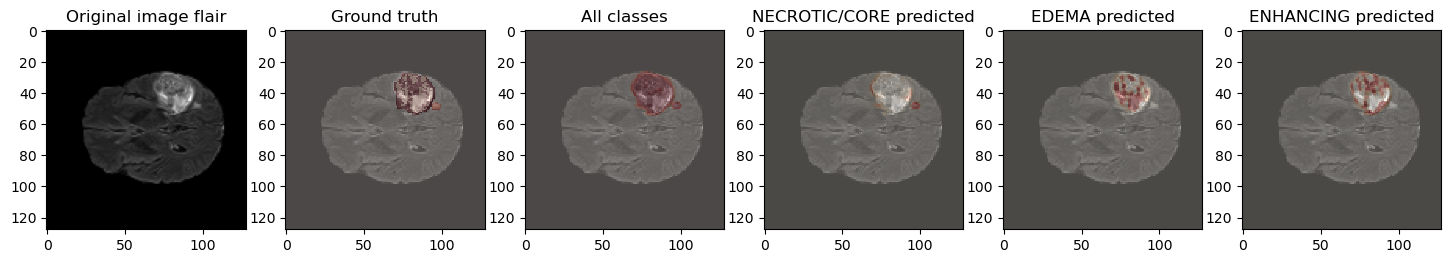

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
start_slice 60 is out of bounds. Using max_slices-1.


<Figure size 1800x5000 with 0 Axes>

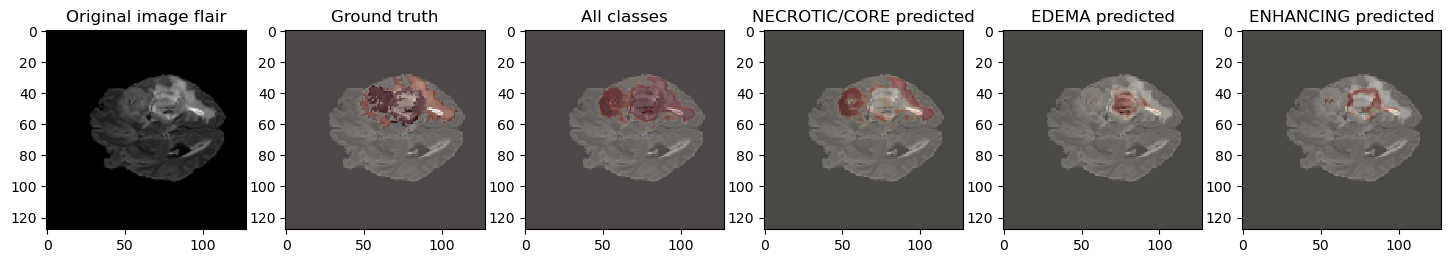

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
start_slice 60 is out of bounds. Using max_slices-1.


<Figure size 1800x5000 with 0 Axes>

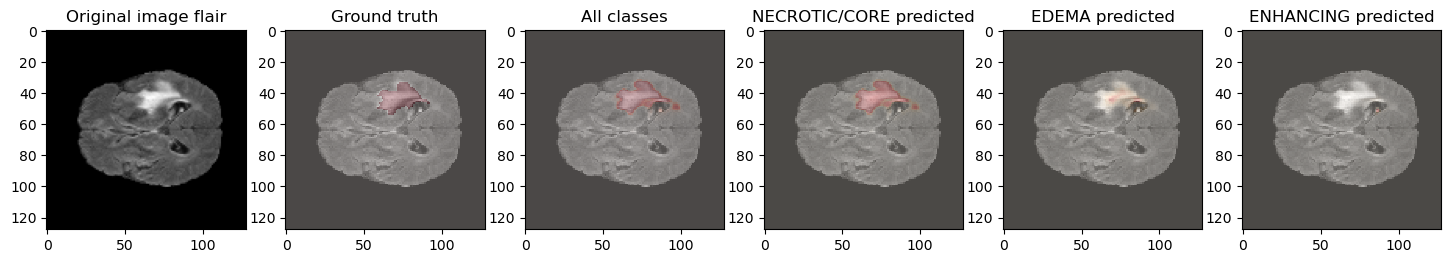

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
start_slice 60 is out of bounds. Using max_slices-1.


<Figure size 1800x5000 with 0 Axes>

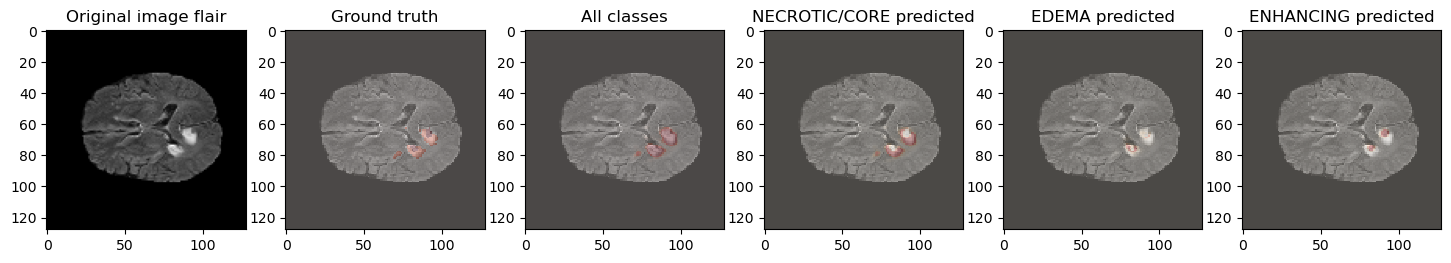

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
start_slice 60 is out of bounds. Using max_slices-1.


<Figure size 1800x5000 with 0 Axes>

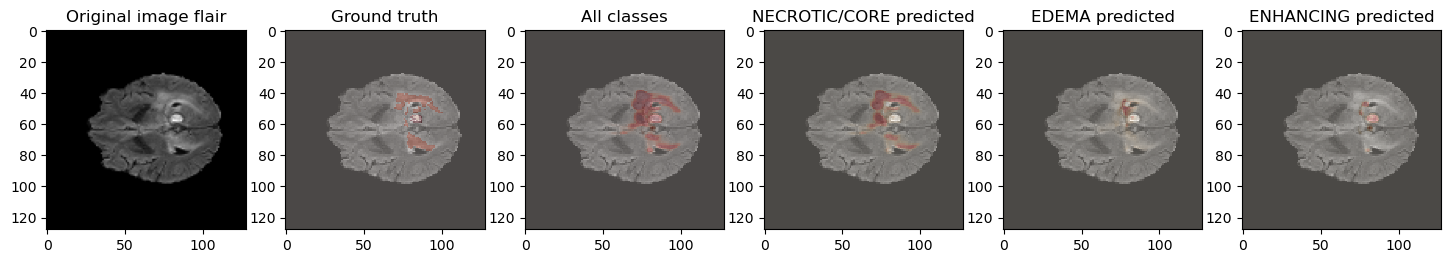

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
start_slice 60 is out of bounds. Using max_slices-1.


<Figure size 1800x5000 with 0 Axes>

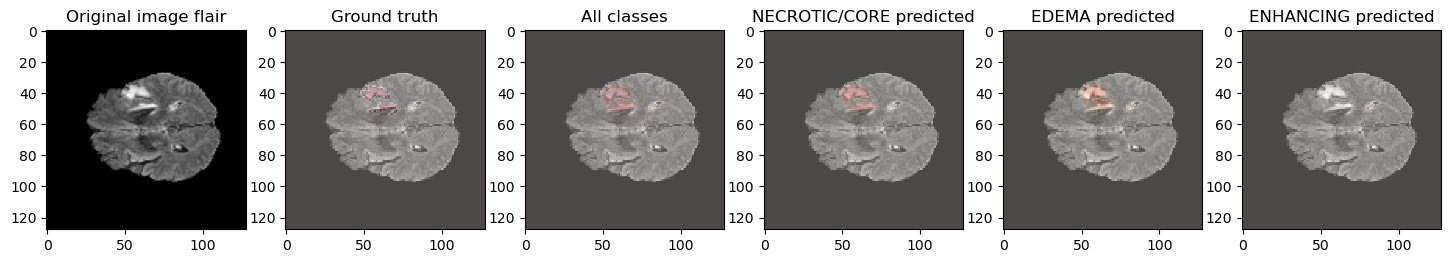

In [72]:
def showPredictsById(case, start_slice=60):
    path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    max_slices = p.shape[0]
    if start_slice >= max_slices:
        print(f"start_slice {start_slice} is out of bounds. Using max_slices-1.")
        start_slice = max_slices - 1

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):  # Add brain background for each image
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4].sum(axis=-1), cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])

# Evaluation

<Figure size 640x480 with 0 Axes>

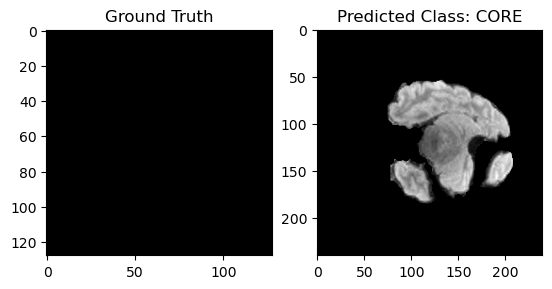

In [80]:
# import os
# import nibabel as nib
# import cv2
# import matplotlib.pyplot as plt

# # Constants
# IMG_SIZE = 128
# VOLUME_START_AT = 0
# SEGMENT_CLASSES = {
#     0: 'NOT tumor',
#     1: 'ENHANCING',
#     2: 'CORE',
#     3: 'WHOLE'
# }

# # Update the base path and case ID
# base_path = "C:/Users/Admin/Downloads/Brats 2023"
# case_id = "00003"  # Change this to the desired case ID
# case_folder = os.path.join(base_path, f"BraTS-GLI-{case_id}-000")

# # Load the segmentation file (ground truth)
# segmentation_file = os.path.join(case_folder, f"BraTS-GLI-00003-000-t2f.nii")
# gt = nib.load(segmentation_file).get_fdata()

# # Dummy predictByPath function (Replace with actual prediction logic)
# def predictByPath(case_folder, case_id):
#     # Simulating prediction output with the same shape as gt for demonstration
#     return nib.load(segmentation_file).get_fdata()

# # Obtain the predicted volumes
# p = predictByPath(case_folder, case_id)
# core = p[:, :, :, 1] if p.ndim == 4 else p  # Handle cases with 4D or 3D predictions
# edema = p[:, :, :, 2] if p.ndim == 4 else p
# enhancing = p[:, :, :, 3] if p.ndim == 4 else p

# # Visualization slice and evaluation class
# i = 40  # Slice index
# eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# # Process ground truth for the specific evaluation class
# gt[gt != eval_class] = 1  # Use only one class for per-class evaluation
# resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# # Plotting
# plt.figure()
# f, axarr = plt.subplots(1, 2)
# axarr[0].imshow(resized_gt, cmap="gray")
# axarr[0].title.set_text('Ground Truth')
# axarr[1].imshow(p[i, :, :, eval_class] if p.ndim == 4 else p[:, :, i], cmap="gray")
# axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
# plt.show()


Files not found for case 00003. Check the dataset paths.
Files not found for case 00005. Check the dataset paths.
Files not found for case 00006. Check the dataset paths.


In [80]:
# case = case=test_ids[3][-3:]
case = "013"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

NotImplementedError: Replace this with your prediction logic.

4/5 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000201815B42C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step


<Figure size 1200x600 with 0 Axes>

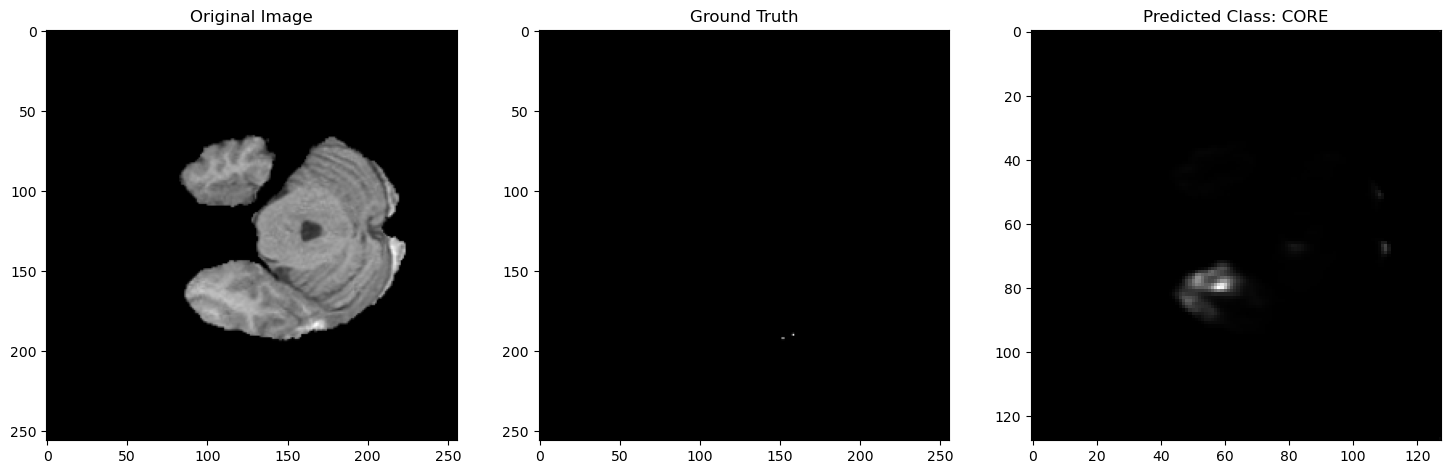

In [65]:
import os
import nibabel as nib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define paths and variables
case = "017"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
original_img = nib.load(os.path.join(path, f'BraTS20_Training_{case}_t1.nii')).get_fdata()  # Replace 't1' with the correct modality

p = predictByPath(path, case)
core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

# Parameters
i = 40  # Slice number
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'
VOLUME_START_AT = 0  # Adjust if your volume starts at a specific index
IMG_SIZE = 256  # Adjust to your resizing dimensions
SEGMENT_CLASSES = {0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'}

# Process ground truth
gt[gt != eval_class] = 1  # Focus on one class for evaluation
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Process original image
original_slice = original_img[:, :, i + VOLUME_START_AT]
resized_original = cv2.resize(original_slice, (IMG_SIZE, IMG_SIZE))

# Plotting
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 3, figsize=(18, 6))

# Display the original image
axarr[0].imshow(resized_original, cmap="gray")
axarr[0].title.set_text('Original Image')

# Display ground truth
axarr[1].imshow(resized_gt, cmap="gray")
axarr[1].title.set_text('Ground Truth')

# Display predicted segmentation
axarr[2].imshow(p[i, :, :, eval_class], cmap="gray")
axarr[2].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')

plt.show()


In [190]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    class_num = y_true.shape[-1]
    dice = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])  # Ensure y_pred_f is defined here
        intersection = K.sum(y_true_f * y_pred_f)
        dice += (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice / class_num

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: could not broadcast input array from shape (256,256) into shape (128,128)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4):
    true_labels = []
    predictions = []
    
    # Limit the number of batches for faster processing
    count = 0
    for batch in test_generator:
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)
        
        # Convert predicted values (one-hot encoded) to class labels
        pred_labels = np.argmax(y_pred, axis=-1).flatten()
        true_labels_batch = np.argmax(y_batch, axis=-1).flatten()

        predictions.extend(pred_labels)
        true_labels.extend(true_labels_batch)
        
        count += len(X_batch)
        if count >= subset_size:
            break
    
    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    print("Confusion Matrix:\n", cm)

    # Display confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(num_classes)])
    cm_display.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Use the function
generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4):
    true_labels = []
    predictions = []
    
    # Limit the number of batches for faster processing
    count = 0
    for batch in test_generator:
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)
        
        # Convert predicted values (one-hot encoded) to class labels
        pred_labels = np.argmax(y_pred, axis=-1).flatten()
        true_labels_batch = np.argmax(y_batch, axis=-1).flatten()

        predictions.extend(pred_labels)
        true_labels.extend(true_labels_batch)
        
        count += len(X_batch)
        if count >= subset_size:
            break
    
    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    print("Confusion Matrix:\n", cm)

    # Normalize the confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle NaN if any row sums to zero

    # Display confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[f"Class {i}" for i in range(num_classes)])
    cm_display.plot(cmap='Blues', values_format='.2f')  # Normalized values for visualization

    plt.title("Confusion Matrix (Normalized)")
    plt.show()

# Use the function
generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4)


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Stopping search: maximum iterations reached --> 2


<Figure size 1200x600 with 0 Axes>

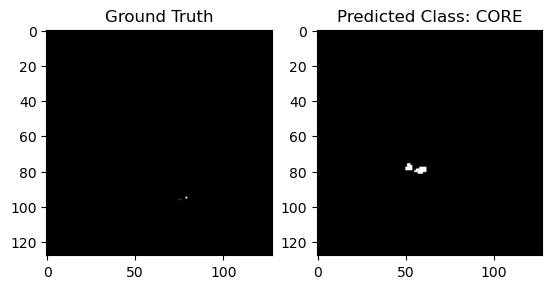

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 160s 160s/step - accuracy: 0.9968 - dice_coef: 0.6896 - dice_coef_edema: 0.8154 - dice_coef_enhancing: 0.7414 - dice_coef_necrotic: 0.7909 - loss: 0.0100 - mean_io_u_3: 0.8316 - precision: 0.9969 - sensitivity: 0.9959 - specificity: 0.9989
test loss, test acc: [0.009997155517339706, 0.9967811107635498, 0.8315684795379639, 0.6895928978919983, 0.9968664646148682, 0.9959323406219482, 0.9989374876022339, 0.7908928394317627, 0.8154103755950928, 0.7414112091064453]


In [64]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
import matplotlib.pyplot as plt

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=2):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

# PSO+Equation Functions
def objective_function(positions, pixels, gamma, m, n):
    positions = positions.reshape(-1, 1)
    K = lambda x, y: np.exp(-np.linalg.norm(x - y))  # Gaussian kernel
    q, c = len(pixels), len(positions)
    u_kl = np.zeros((c, q))
    t_kl = np.zeros((c, q))
    psi_k = np.zeros(c)
    v_k = np.zeros_like(positions)
    
    for k in range(c):
        for l in range(q):
            t_kl[k, l] = ((1 + gamma[l] * psi_k[k] * (1 - K(pixels[l], positions[k]))) ** (1 / (n - 1))) ** -1
            u_kl[k, l] = 1 / np.sum([(gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j])) 
                                      + psi_k[j] * (1 - t_kl[j, l]) ** n) ** (1 / (m - 1)) for j in range(c)])
        psi_k[k] = np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n * (2 - 2 * K(pixels[l], positions[k])) for l in range(q)]) / \
                   np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n for l in range(q)])
        v_k[k] = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) * pixels[l]
                         for l in range(q)]) / \
                 np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) for l in range(q)])
    
    J_m = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * (1 - K(pixels[l], positions[k])) 
                  + psi_k[k] * u_kl[k, l] * (1 - t_kl[k, l]) ** n for k in range(c) for l in range(q)])
    return J_m

def perform_pso_optimization(pixels, num_centroids, num_particles, gamma, m, n):
    lower_bound = np.zeros(num_centroids)
    upper_bound = np.ones(num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, args=(pixels, gamma, m, n), swarmsize=num_particles, maxiter=2)
    return result.reshape(-1, 1)

def perform_image_segmentation(image, num_clusters, num_particles, gamma, m, n):
    pixels = image.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)
    centroids = perform_pso_optimization(pixels, num_clusters, num_particles, gamma, m, n)
    labels = KMeans(n_clusters=num_clusters, init=centroids, n_init=1).fit_predict(pixels)
    segmented_image = centroids[labels].reshape(image.shape)
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)

# Prediction Function
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
# case = test_ids[3][-3:]
case = "017"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation
gamma = np.random.rand(p[i, :, :, eval_class].size)

segmented_prediction = perform_image_segmentation(
    p[i, :, :, eval_class], 
    num_clusters=3, 
    num_particles=20, 
    gamma=gamma, 
    m=2, 
    n=2
)

# Display
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


In [207]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adadelta(learning_rate=1.0),  # Adadelta optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.9985 - dice_coef: 0.7115 - dice_coef_edema: 0.8419 - dice_coef_enhancing: 0.8359 - dice_coef_necrotic: 0.8453 - loss: 0.0041 - mean_io_u_5: 0.8413 - precision: 0.9985 - sensitivity: 0.9981 - specificity: 0.9995
test loss, test acc: [0.004112735390663147, 0.998526394367218, 0.8413101434707642, 0.7114793062210083, 0.9984949231147766, 0.9981376528739929, 0.9994909167289734, 0.8453227281570435, 0.8419356942176819, 0.8358855843544006]


In [208]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),  # Adagrad optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.9983 - dice_coef: 0.7306 - dice_coef_edema: 0.8966 - dice_coef_enhancing: 0.8552 - dice_coef_necrotic: 0.8030 - loss: 0.0051 - mean_io_u_6: 0.8537 - precision: 0.9982 - sensitivity: 0.9978 - specificity: 0.9994
test loss, test acc: [0.00508109712973237, 0.9983133673667908, 0.853714644908905, 0.7305639982223511, 0.9982444047927856, 0.9977818131446838, 0.9994019865989685, 0.8029536604881287, 0.8965612649917603, 0.8552382588386536]


In [209]:
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),  # Change to Adam optimizer with a specific learning rate
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 145s 145s/step - accuracy: 0.9978 - dice_coef: 0.6813 - dice_coef_edema: 0.8489 - dice_coef_enhancing: 0.7626 - dice_coef_necrotic: 0.7829 - loss: 0.0066 - mean_io_u_7: 0.8362 - precision: 0.9978 - sensitivity: 0.9971 - specificity: 0.9993
test loss, test acc: [0.006556036416441202, 0.9977734088897705, 0.8362389802932739, 0.6812748908996582, 0.997780978679657, 0.9971329569816589, 0.9992518424987793, 0.7828513383865356, 0.8489059805870056, 0.7626119256019592]


In [ ]:
from tensorflow.keras import optimizers
model.add(Dense(num_classes, activation='sigmoid'))  # Assuming you are using sigmoid for a multi-label classification task

model.compile(
    loss="binary_crossentropy",  # Use binary_crossentropy for sigmoid activation
    optimizer=optimizers.Adam(learning_rate=0.001),  # Use Adam optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


In [213]:
from tensorflow.keras import optimizers

# Modify the output layer to use Softmax activation (for multi-class classification)
model.add(Dense(num_classes, activation='softmax'))  # Softmax activation for multi-class classification

# Compile the model with categorical crossentropy loss
model.compile(
    loss="categorical_crossentropy",  # Categorical crossentropy is used for multi-class classification
    optimizer=optimizers.Adam(learning_rate=0.001),  # Use Adam optimizer or another optimizer of choice
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


AttributeError: 'Functional' object has no attribute 'add'

In [215]:
#1. Adam Optimizer
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 110s 110s/step - accuracy: 0.9980 - dice_coef: 0.6541 - dice_coef_edema: 0.8376 - dice_coef_enhancing: 0.7276 - dice_coef_necrotic: 0.7407 - loss: 0.0058 - mean_io_u_8: 0.8317 - precision: 0.9981 - sensitivity: 0.9975 - specificity: 0.9993
test loss, test acc: [0.005809776019304991, 0.9980250000953674, 0.8316761255264282, 0.6541388034820557, 0.9980579614639282, 0.9974578619003296, 0.9993433952331543, 0.740720272064209, 0.8375884890556335, 0.7276397347450256]


In [216]:
#2. SGD Optimizer
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),  # SGD optimizer with momentum
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 112s 112s/step - accuracy: 0.9985 - dice_coef: 0.7115 - dice_coef_edema: 0.8419 - dice_coef_enhancing: 0.8359 - dice_coef_necrotic: 0.8453 - loss: 0.0041 - mean_io_u_9: 0.8413 - precision: 0.9985 - sensitivity: 0.9981 - specificity: 0.9995
test loss, test acc: [0.00411273492500186, 0.998526394367218, 0.8413101434707642, 0.7114793062210083, 0.9984949231147766, 0.9981376528739929, 0.9994909763336182, 0.8453227281570435, 0.8419355750083923, 0.8358857035636902]


In [217]:
#3. Adagrad Optimizer
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adagrad(learning_rate=0.01),  # Adagrad optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 108s 108s/step - accuracy: 0.9979 - dice_coef: 0.6864 - dice_coef_edema: 0.8885 - dice_coef_enhancing: 0.8129 - dice_coef_necrotic: 0.7069 - loss: 0.0064 - mean_io_u_10: 0.8371 - precision: 0.9978 - sensitivity: 0.9973 - specificity: 0.9993
test loss, test acc: [0.00637228274717927, 0.9978882074356079, 0.8370674848556519, 0.6863550543785095, 0.997840404510498, 0.9972532987594604, 0.999268651008606, 0.7068639993667603, 0.8885056376457214, 0.8128858804702759]


In [218]:
#4. RMSprop Optimizer
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=0.001),  # RMSprop optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 103s 103s/step - accuracy: 0.9979 - dice_coef: 0.6864 - dice_coef_edema: 0.8885 - dice_coef_enhancing: 0.8129 - dice_coef_necrotic: 0.7069 - loss: 0.0064 - mean_io_u_11: 0.8371 - precision: 0.9978 - sensitivity: 0.9973 - specificity: 0.9993
test loss, test acc: [0.00637228274717927, 0.9978882074356079, 0.8370674848556519, 0.6863550543785095, 0.997840404510498, 0.9972532987594604, 0.999268651008606, 0.7068639993667603, 0.8885056376457214, 0.8128858804702759]


In [219]:
#5. Adadelta Optimizer
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adadelta(learning_rate=1.0),  # Adadelta optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.9980 - dice_coef: 0.7245 - dice_coef_edema: 0.8848 - dice_coef_enhancing: 0.8634 - dice_coef_necrotic: 0.8014 - loss: 0.0057 - mean_io_u_12: 0.8475 - precision: 0.9979 - sensitivity: 0.9974 - specificity: 0.9993
test loss, test acc: [0.005746145732700825, 0.9980151057243347, 0.8474633097648621, 0.7245211005210876, 0.9979012608528137, 0.9974432587623596, 0.9992893934249878, 0.8013718128204346, 0.8848324418067932, 0.8633749485015869]


In [220]:
#6. Nadam Optimizer
from tensorflow.keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Nadam(learning_rate=0.001),  # Nadam optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - accuracy: 0.9981 - dice_coef: 0.6809 - dice_coef_edema: 0.8540 - dice_coef_enhancing: 0.7915 - dice_coef_necrotic: 0.7645 - loss: 0.0056 - mean_io_u_13: 0.8350 - precision: 0.9981 - sensitivity: 0.9976 - specificity: 0.9994
test loss, test acc: [0.0056294347159564495, 0.9980971813201904, 0.8349943161010742, 0.6809255480766296, 0.998113751411438, 0.9975554347038269, 0.9993636608123779, 0.7645086050033569, 0.8539955019950867, 0.7914524078369141]


In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
import matplotlib.pyplot as plt

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=2):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

# PSO+Equation Functions
def objective_function(positions, pixels, gamma, m, n):
    positions = positions.reshape(-1, 1)
    K = lambda x, y: np.exp(-np.linalg.norm(x - y))  # Gaussian kernel
    q, c = len(pixels), len(positions)
    u_kl = np.zeros((c, q))
    t_kl = np.zeros((c, q))
    psi_k = np.zeros(c)
    v_k = np.zeros_like(positions)
    
    for k in range(c):
        for l in range(q):
            t_kl[k, l] = ((1 + gamma[l] * psi_k[k] * (1 - K(pixels[l], positions[k]))) ** (1 / (n - 1))) ** -1
            u_kl[k, l] = 1 / np.sum([(gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j])) 
                                      + psi_k[j] * (1 - t_kl[j, l]) ** n) ** (1 / (m - 1)) for j in range(c)])
            # u_kl[k, l] = 1 / np.sum([ 
            #                           + psi_k[j] * (1 - t_kl[j, l]) ** n)(gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j])) 
            #                           + psi_k[j] * (1 - t_kl[j, l]) ** n) ** (1 / (m - 1)) for j in range(c)])
        psi_k[k] = np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n * (2 - 2 * K(pixels[l], positions[k])) for l in range(q)]) / \
                   np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n for l in range(q)])
        v_k[k] = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) * pixels[l]
                         for l in range(q)]) / \
                 np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) for l in range(q)])
    
    J_m = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * (1 - K(pixels[l], positions[k])) 
                  + psi_k[k] * u_kl[k, l] * (1 - t_kl[k, l]) ** n for k in range(c) for l in range(q)])
    return J_m

def perform_pso_optimization(pixels, num_centroids, num_particles, gamma, m, n):
    lower_bound = np.zeros(num_centroids)
    upper_bound = np.ones(num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, args=(pixels, gamma, m, n), swarmsize=num_particles, maxiter=2)
    return result.reshape(-1, 1)

def perform_image_segmentation(image, num_clusters, num_particles, gamma, m, n):
    pixels = image.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)
    centroids = perform_pso_optimization(pixels, num_clusters, num_particles, gamma, m, n)
    labels = KMeans(n_clusters=num_clusters, init=centroids, n_init=1).fit_predict(pixels)
    segmented_image = centroids[labels].reshape(image.shape)
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)

# Prediction Function
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
# case = test_ids[3][-3:]
case = "014"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation
gamma = np.random.rand(p[i, :, :, eval_class].size)
# gamma = np.full(p[i, :, :, eval_class].size, 0.5)  # Use a constant value

segmented_prediction = perform_image_segmentation(
    p[i, :, :, eval_class], 
    num_clusters=3, 
    num_particles=20, 
    gamma=gamma, 
    m=2, 
    n=2
)

# Display
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step



KeyboardInterrupt



5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


<Figure size 1200x600 with 0 Axes>

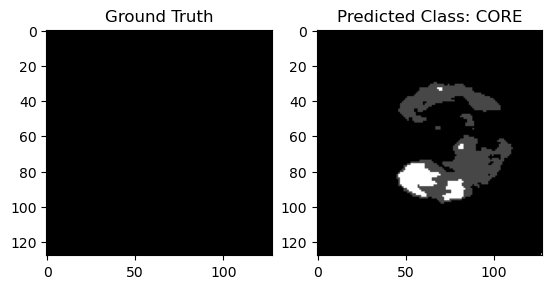

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 145s 145s/step - accuracy: 0.9953 - dice_coef: 0.6677 - dice_coef_edema: 0.8544 - dice_coef_enhancing: 0.7644 - dice_coef_necrotic: 0.6228 - loss: 0.0145 - mean_io_u_14: 0.8481 - precision: 0.9954 - sensitivity: 0.9943 - specificity: 0.9985
test loss, test acc: [0.014482882805168629, 0.9952752590179443, 0.8481411933898926, 0.6677196621894836, 0.9954232573509216, 0.994296669960022, 0.9984549283981323, 0.6228164434432983, 0.8543887734413147, 0.7644352912902832]


In [100]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz  # Alternative for Fuzzy C-Means

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=2):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

# FCM-based Segmentation using skfuzzy
def perform_fcm_segmentation(image, num_clusters):
    pixels = image.flatten()
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data=pixels.reshape(1, -1),
        c=num_clusters,
        m=2,
        error=0.005,
        maxiter=10,
        init=None
    )
    labels = np.argmax(u, axis=0)
    segmented_image = cntr[labels].reshape(image.shape)
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    return img_as_ubyte(segmented_image).astype(np.uint8)

# Prediction Function
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
case = "013"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation
segmented_prediction = perform_fcm_segmentation(
    p[i, :, :, eval_class], 
    num_clusters=3
)

# Display
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

# Model Evaluation
model.compile(
    loss="categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]
)

# Evaluate the model on the test data
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Stopping search: maximum iterations reached --> 50


<Figure size 1200x600 with 0 Axes>

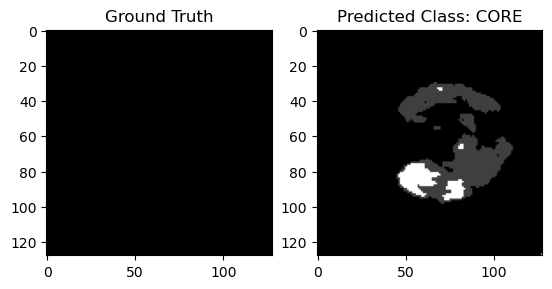

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 139s 139s/step - accuracy: 0.9966 - dice_coef: 0.6744 - dice_coef_edema: 0.8672 - dice_coef_enhancing: 0.8074 - dice_coef_necrotic: 0.5767 - loss: 0.0109 - mean_io_u_20: 0.8404 - precision: 0.9966 - sensitivity: 0.9959 - specificity: 0.9989
test loss, test acc: [0.010851534083485603, 0.9965912103652954, 0.8403842449188232, 0.6743988990783691, 0.996616005897522, 0.9959182739257812, 0.9988575577735901, 0.5766926407814026, 0.8671575784683228, 0.8073659539222717]


In [114]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyswarm import pso  # PSO library for optimization

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=2):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

# PSO-based Segmentation
def objective_function(centroids, pixels):
    centroids = centroids.reshape(-1, 1)
    distances = np.abs(pixels - centroids[:, np.newaxis])
    return np.sum(np.min(distances, axis=0))

def perform_pso_segmentation(image, num_clusters, num_particles):
    pixels = image.flatten().reshape(-1, 1)  # Reshape to (num_pixels, 1)
    scaler = StandardScaler()
    pixels_scaled = scaler.fit_transform(pixels)

    lower_bound = [np.min(pixels_scaled)] * num_clusters
    upper_bound = [np.max(pixels_scaled)] * num_clusters

    def wrapped_objective(centroids):
        centroids = np.array(centroids).reshape(-1, 1)  # Ensure centroids are reshaped to (num_clusters, 1)
        distances = np.abs(pixels_scaled - centroids.T)  # Match shapes for broadcasting
        return np.sum(np.min(distances, axis=1))  # Minimize distances to nearest centroids

    centroids, _ = pso(wrapped_objective, lower_bound, upper_bound, swarmsize=num_particles, maxiter=50)

    # Assign clusters based on nearest centroids
    centroids = np.array(centroids).reshape(-1, 1)  # Reshape centroids to (num_clusters, 1)
    distances = np.abs(pixels_scaled - centroids.T)  # Compute distances
    labels = np.argmin(distances, axis=1)  # Find nearest centroid for each pixel
    segmented_image = centroids[labels].reshape(image.shape)  # Map centroids to image shape
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)


# Prediction Function
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
case = "013"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation
segmented_prediction = perform_pso_segmentation(
    p[i, :, :, eval_class], 
    num_clusters=3, 
    num_particles=20
)

# Display
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

# Model Evaluation
model.compile(
    loss="categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]
)

# Evaluate the model on the test data
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Stopping search: maximum iterations reached --> 50


<Figure size 1200x600 with 0 Axes>

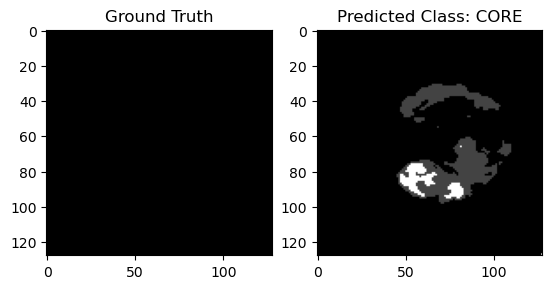

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 110s 110s/step - accuracy: 0.9965 - dice_coef: 0.6715 - dice_coef_edema: 0.8649 - dice_coef_enhancing: 0.6636 - dice_coef_necrotic: 0.6745 - loss: 0.0113 - mean_io_u_21: 0.8467 - precision: 0.9966 - sensitivity: 0.9959 - specificity: 0.9988
test loss, test acc: [0.011323017999529839, 0.9964938163757324, 0.8466529846191406, 0.6715042591094971, 0.9965822100639343, 0.9958570003509521, 0.9988452196121216, 0.6744621992111206, 0.8649309873580933, 0.6636245846748352]


In [116]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
from skfuzzy.cluster import cmeans
import matplotlib.pyplot as plt

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=2):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

# PSO+FCM Functions
def pso_fcm_objective(centroids, pixels, m):
    """Objective function for PSO combined with Fuzzy C-Means."""
    # Ensure centroids and pixels have correct shapes
    centroids = np.array(centroids).flatten()  # Shape (num_clusters,)
    pixels = pixels.flatten()  # Shape (num_pixels,)
    
    # Compute distances between pixels and centroids
    distances = np.abs(pixels[:, np.newaxis] - centroids[np.newaxis, :])  # Shape (num_pixels, num_clusters)
    
    # Avoid division by zero
    distances = np.fmax(distances, np.finfo(np.float64).eps)
    
    # Compute membership degrees
    membership = 1.0 / (distances ** (2 / (m - 1)))
    membership /= np.sum(membership, axis=1, keepdims=True)  # Normalize membership values
    
    # Compute the objective function
    J_m = np.sum((membership ** m) * (distances ** 2))
    return J_m

def perform_pso_fcm(pixels, num_clusters, num_particles, m):
    """Perform PSO optimization to initialize centroids for FCM."""
    pixels = pixels.flatten()  # Ensure pixels is 1D
    lower_bound = np.full(num_clusters, np.min(pixels))
    upper_bound = np.full(num_clusters, np.max(pixels))

    # Optimize centroids using PSO
    best_centroids, _ = pso(
        pso_fcm_objective, 
        lower_bound, 
        upper_bound, 
        args=(pixels, m), 
        swarmsize=num_particles, 
        maxiter=50
    )
    
    # Prepare data for FCM
    pixels = pixels[np.newaxis, :]  # Reshape to (1, num_pixels)
    best_centroids = np.array(best_centroids).flatten()  # Shape (num_clusters,)

    # Initialize fuzzy membership matrix
    u0 = np.random.dirichlet(np.ones(num_clusters), size=pixels.shape[1]).T  # Shape (num_clusters, num_pixels)

    # Perform FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(
        pixels, 
        c=num_clusters, 
        m=m, 
        error=0.005, 
        maxiter=100, 
        init=u0
    )
    return cntr, u



def perform_image_segmentation(image, num_clusters, num_particles, m):
    """Perform image segmentation using PSO+FCM."""
    pixels = image.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels).flatten()

    # Perform PSO + FCM
    centroids, membership = perform_pso_fcm(pixels, num_clusters, num_particles, m)

    # Assign each pixel to the cluster with the highest membership
    labels = np.argmax(membership, axis=0)
    segmented_image = centroids[labels].reshape(image.shape)

    # Rescale the segmented image to 8-bit range
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)

# Prediction Function
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
case = "013"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation
segmented_prediction = perform_image_segmentation(
    p[i, :, :, eval_class], 
    num_clusters=3, 
    num_particles=20, 
    m=2
)

# Display
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[
    'accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, 
    dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
])

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4):
    true_labels = []
    predictions = []
    
    # Limit the number of batches for faster processing
    count = 0
    for batch in test_generator:
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)
        
        # Convert predicted values (one-hot encoded) to class labels
        pred_labels = np.argmax(y_pred, axis=-1).flatten()
        true_labels_batch = np.argmax(y_batch, axis=-1).flatten()

        predictions.extend(pred_labels)
        true_labels.extend(true_labels_batch)
        
        count += len(X_batch)
        if count >= subset_size:
            break
    
    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    print("Confusion Matrix:\n", cm)

    # Normalize the confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle NaN if any row sums to zero

    # Display confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[f"Class {i}" for i in range(num_classes)])
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_display.plot(cmap='Blues', ax=ax, values_format='.2f')

    # Adjust the color range manually
    im = ax.images[0]  # Access the image created by `plot`
    im.set_clim(0.2, 1.6)  # Set the color limits

    plt.title("Confusion Matrix (Test)")
    plt.show()

# Use the function
generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4)


 9/20 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
Confusion Matrix:
 [[10089689      177     5493      254]
 [    1070     7155     2069     1430]
 [    9136      182    25736      131]
 [    3671     1139     1897     8851]]


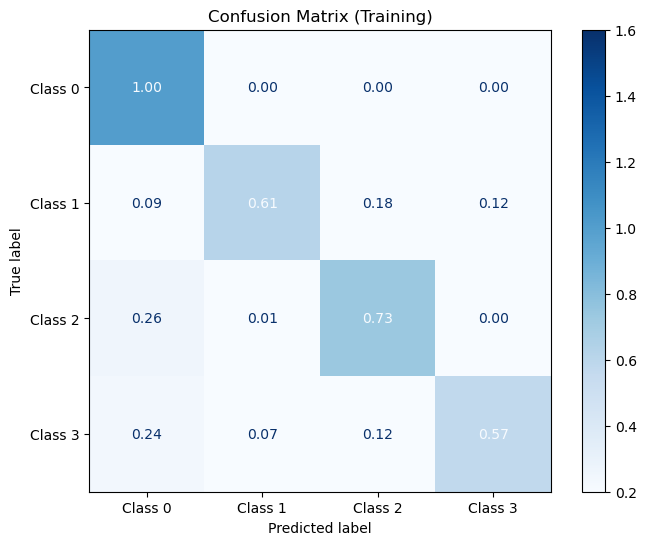

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def generate_confusion_matrix_display(model, training_generator, subset_size=100, num_classes=4):
    true_labels = []
    predictions = []
    
    # Limit the number of batches for faster processing
    count = 0
    for batch in training_generator:
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)
        
        # Convert predicted values (one-hot encoded) to class labels
        pred_labels = np.argmax(y_pred, axis=-1).flatten()
        true_labels_batch = np.argmax(y_batch, axis=-1).flatten()

        predictions.extend(pred_labels)
        true_labels.extend(true_labels_batch)
        
        count += len(X_batch)
        if count >= subset_size:
            break
    
    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    print("Confusion Matrix:\n", cm)

    # Normalize the confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle NaN if any row sums to zero

    # Display confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[f"Class {i}" for i in range(num_classes)])
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_display.plot(cmap='Blues', ax=ax, values_format='.2f')

    # Adjust the color range manually
    im = ax.images[0]  # Access the image created by `plot`
    im.set_clim(0.2, 1.6)  # Set the color limits

    plt.title("Confusion Matrix (Training)")
    plt.show()

# Use the function
generate_confusion_matrix_display(model, training_generator, subset_size=100, num_classes=4)


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Confusion Matrix:
 [[10016179      327     7930      213]
 [     384     9363      838     1370]
 [   15086     1249    83586     1276]
 [    1292     2068     2255    14664]]


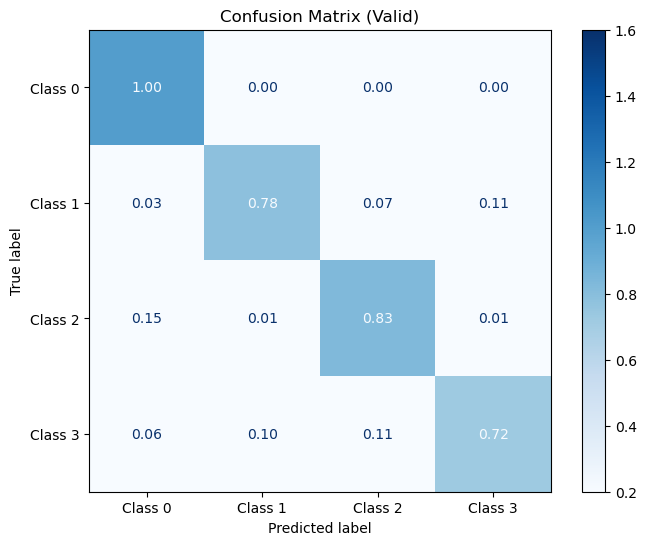

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def generate_confusion_matrix_display(model, valid_generator, subset_size=100, num_classes=4):
    true_labels = []
    predictions = []
    
    # Limit the number of batches for faster processing
    count = 0
    for batch in valid_generator:
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)
        
        # Convert predicted values (one-hot encoded) to class labels
        pred_labels = np.argmax(y_pred, axis=-1).flatten()
        true_labels_batch = np.argmax(y_batch, axis=-1).flatten()

        predictions.extend(pred_labels)
        true_labels.extend(true_labels_batch)
        
        count += len(X_batch)
        if count >= subset_size:
            break
    
    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    print("Confusion Matrix:\n", cm)

    # Normalize the confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle NaN if any row sums to zero

    # Display confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[f"Class {i}" for i in range(num_classes)])
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_display.plot(cmap='Blues', ax=ax, values_format='.2f')

    # Adjust the color range manually
    im = ax.images[0]  # Access the image created by `plot`
    im.set_clim(0.2, 1.6)  # Set the color limits

    plt.title("Confusion Matrix (Valid)")
    plt.show()

# Use the function
generate_confusion_matrix_display(model, valid_generator, subset_size=100, num_classes=4)


In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_roc_curve(model, generator, class_names):
#     """
#     Plots ROC curve for each class using the given model and test data generator.

#     Args:
#     - model: Trained Keras model.
#     - generator: Data generator for the test dataset.
#     - class_names: List of class names corresponding to segmentation classes.

#     Returns:
#     - None (Plots ROC curves).
#     """
#     y_true_all = []
#     y_pred_all = []

#     # Collect predictions and true labels from the generator
#     for batch in generator:
#         X_batch, y_true_batch = batch
#         y_pred_batch = model.predict(X_batch, verbose=0)
#         y_true_all.append(y_true_batch)
#         y_pred_all.append(y_pred_batch)

#     y_true_all = np.concatenate(y_true_all, axis=0)
#     y_pred_all = np.concatenate(y_pred_all, axis=0)

#     # Plot ROC curve for each class
#     plt.figure(figsize=(10, 8))
#     for i, class_name in enumerate(class_names):
#         # Flatten predictions and true labels for the current class
#         y_true_class = y_true_all[:, :, :, i].ravel()
#         y_pred_class = y_pred_all[:, :, :, i].ravel()

#         # Compute ROC curve and AUC
#         fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
#         roc_auc = auc(fpr, tpr)

#         # Plot the ROC curve
#         plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

#     # Plot settings
#     plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve for Segmentation Classes')
#     plt.legend(loc="lower right")
#     plt.show()

# # List of segmentation class names (update as necessary)
# SEGMENT_CLASSES = ['NOT tumor', 'NECROTIC', 'EDEMA', 'ENHANCING']

# # Call the function to plot ROC curve
# plot_roc_curve(model, test_generator, SEGMENT_CLASSES)


In [ ]:
rpint()

In [ ]:
# 1. Initialize Parameters:
#    - Set IMAGE_SIZE = 128 (image resolution)
#    - Set NUM_CLASSES = 4 (e.g., "NOT tumor", "ENHANCING", "CORE", "WHOLE")
#    - Set NUM_PARTICLES (number of PSO particles)
#    - Set NUM_ITERATIONS (number of PSO iterations)
#    - Set m (fuzziness parameter)
#    - Set n (distance measure exponent)
   
# 2. Load Image:
#    - Load the 3D image data (e.g., MRI scan).
#    - Preprocess the image (e.g., apply anisotropic diffusion and sharpening filters).

# 3. Fuzzy C-Means Initialization:
#    - Initialize fuzzy membership matrix `u_ik` randomly.
#    - Initialize centroids `c_k` based on image data.

# 4. Particle Swarm Optimization Setup:
#    - Initialize PSO particles (centroids) randomly within the image intensity range.
#    - Set velocity and position for each particle.

# 5. PSO Optimization Loop (for each iteration):
#    - For each particle (centroid):
#      - Calculate the **objective function** based on the fuzzy membership and centroids:
#        - For each pixel `i` and centroid `k`, calculate the distance `d_ik`.
#        - Update the fuzzy membership `u_ik` using the FCM update rule.
#        - Update centroids `c_k` using the FCM centroid update rule.
#      - Evaluate the **objective function** (e.g., sum of squared distances between pixels and centroids).
#      - Update the particle velocity and position using PSO update rules:
#        - Calculate velocity: `v_i(t+1) = w * v_i(t) + c1 * r1 * (pbest_i - x_i) + c2 * r2 * (gbest_i - x_i)`
#        - Update position: `x_i(t+1) = x_i(t) + v_i(t+1)`
#    - If convergence is reached (i.e., change in centroids is minimal), stop PSO optimization.

# 6. Perform Image Clustering:
#    - Use the optimized centroids from PSO to cluster the pixels using **KMeans**:
#      - Assign each pixel to the nearest centroid.
#      - Create the segmented image by assigning each pixel its respective class (centroid).

# 7. Rescale and Normalize:
#    - Normalize the segmented image to the range [0, 255].
#    - Convert the segmented image to an 8-bit format (`uint8`).

# 8. Optional Post-Processing:
#    - Apply morphological operations (e.g., erosion, dilation) to remove small artifacts.

# 9. Display Results:
#    - Visualize the **Ground Truth** and **Predicted Segmented Image** side by side.

# 10. End.


In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyswarm import pso  # Ensure you have the PSO library installed
import matplotlib.pyplot as plt

# Preprocessing and Segmentation Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    """
    Apply sharpening to each 2D slice of a 3D image.
    """
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    
    # Apply the sharpening kernel to each slice
    for i in range(img.shape[-1]):  # Iterate over the last dimension
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    
    return img_sharpened


def skull_stripping(img, se_closing, se_erosion):
    closed = morphology.binary_closing(img > img.mean(), selem=se_closing)
    eroded = morphology.binary_erosion(closed, selem=se_erosion)
    return img * eroded

def objective_function(positions, pixels):
    centroids = positions.reshape(-1, 1)
    labels = KMeans(n_clusters=len(centroids), init=centroids, n_init=1).fit_predict(pixels)
    mse = np.mean((pixels - centroids[labels]) ** 2)
    return mse

def perform_pso_optimization(pixels, num_centroids, num_particles):
    lower_bound = np.zeros(pixels.shape[1] * num_centroids)
    upper_bound = np.ones(pixels.shape[1] * num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, args=(pixels,), swarmsize=num_particles, maxiter=100)
    centroids = result.reshape(-1, 1)
    return centroids

def perform_image_segmentation(image, num_centroids, num_particles):
    pixels = image.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)
    centroids = perform_pso_optimization(pixels, num_centroids, num_particles)
    labels = KMeans(n_clusters=num_centroids, init=centroids, n_init=1).fit_predict(pixels)
    segmented_image = centroids[labels].reshape(image.shape)
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)

# Updated Prediction Function
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)  # Apply anisotropic diffusion filter
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)  # Sharpen T1-CE image
    
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
case = "013"
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation on prediction
segmented_prediction = perform_image_segmentation(p[i, :, :, eval_class], num_centroids=3, num_particles=10)

# Display
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# def dice_coef(y_true, y_pred, smooth=1):
#     class_num = 4
#     dice = 0
#     for i in range(class_num):
#         y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
#         # y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])
#         intersection = K.sum(y_true_f * y_pred_f)
#         dice += (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice / class_num
#     import tensorflow as tf
# from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    class_num = y_true.shape[-1]
    dice = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])  # Ensure y_pred_f is defined here
        intersection = K.sum(y_true_f * y_pred_f)
        dice += (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice / class_num



In [ ]:

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4):
    true_labels = []
    predictions = []
    
    # Limit the number of batches for faster processing
    count = 0
    for batch in test_generator:
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)
        
        # Convert predicted values (one-hot encoded) to class labels
        pred_labels = np.argmax(y_pred, axis=-1).flatten()
        true_labels_batch = np.argmax(y_batch, axis=-1).flatten()

        predictions.extend(pred_labels)
        true_labels.extend(true_labels_batch)
        
        count += len(X_batch)
        if count >= subset_size:
            break
    
    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    print("Confusion Matrix:\n", cm)

    # Normalize the confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle NaN if any row sums to zero

    # Display confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[f"Class {i}" for i in range(num_classes)])
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_display.plot(cmap='Blues', ax=ax, values_format='.2f')

    # Adjust the color range manually
    im = ax.images[0]  # Access the image created by `plot`
    im.set_clim(0.2, 1.6)  # Set the color limits

    plt.title("Confusion Matrix (Normalized)")
    plt.show()

# Use the function
generate_confusion_matrix_display(model, test_generator, subset_size=100, num_classes=4)


In [ ]:
prit(0)nfd

In [ ]:
# from sklearn.metrics import confusion_matrix, roc_curve, auc
# from sklearn.preprocessing import label_binarize
# import seaborn as sns


In [ ]:
# def plot_confusion_matrix(y_true, y_pred, class_names):
#     """
#     Plot the confusion matrix with annotations.
#     """
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel("Predicted Labels")
#     plt.ylabel("True Labels")
#     plt.title("Confusion Matrix")
#     plt.show()


In [ ]:
# def plot_roc_curve(y_true, y_pred_proba, num_classes):
#     """
#     Plot ROC curve for multi-class classification.
#     """
#     y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
#     fpr = {}
#     tpr = {}
#     roc_auc = {}
    
#     for i in range(num_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Plot all ROC curves
#     plt.figure(figsize=(10, 8))
#     for i in range(num_classes):
#         plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    
#     plt.plot([0, 1], [0, 1], 'k--', label="Random")
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("Multi-class ROC Curve")
#     plt.legend(loc="lower right")
#     plt.show()


In [ ]:
# print(f"y_true shape: {y_true.shape}")
# print(f"valid_mask shape: {valid_mask.shape}")
# print(f"y_pred shape: {y_pred.shape}")
# valid_mask = valid_mask.flatten()  # Flatten mask
# y_true = y_true.flatten()         # Flatten ground truth
# y_pred = y_pred.flatten()         # Flatten predictions
# # Flatten ground truth and predictions
# y_true = gt.flatten().astype(int)  # Flattened ground truth
# y_pred = np.argmax(p, axis=-1).flatten()  # Flattened predicted labels

# # Create valid mask based on y_true
# valid_mask = y_true != -1  # Replace -1 with any invalid class or mask criteria

# # Apply the valid mask consistently
# y_true = y_true[valid_mask]
# y_pred = y_pred[valid_mask]  # Ensure y_pred matches y_true in shape


In [ ]:
# # Get predictions and ground truth
# y_true = gt.flatten().astype(int)  # Flattened ground truth labels
# y_pred = np.argmax(p, axis=-1).flatten()  # Flattened predicted labels
# y_pred_proba = p.reshape(-1, p.shape[-1])  # Predicted probabilities for all classes

# # Class names (replace with actual class names)
# class_names = ['NOT tumor', 'ENHANCING', 'CORE', 'WHOLE']

# # Plot Confusion Matrix
# plot_confusion_matrix(y_true, y_pred, class_names)

# # Plot ROC Curve
# plot_roc_curve(y_true, y_pred_proba, num_classes=len(class_names))


In [ ]:
# Updated Prediction Function with PSO-GWO and FCM Segmentation
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Load and preprocess flair
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)  # Apply anisotropic diffusion filter
    
    # Load and preprocess t1ce
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)  # Sharpen T1-CE image
    
    # Resize and normalize slices
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    
    # Predict tumor probabilities
    predictions = model.predict(X / np.max(X), verbose=1)
    
    # Perform PSO-GWO-based FCM segmentation on predictions
    segmented_predictions = np.zeros_like(predictions)
    for slice_idx in range(VOLUME_SLICES):
        for class_idx in range(predictions.shape[-1]):  # Iterate through tumor classes
            segmented_predictions[slice_idx, :, :, class_idx] = perform_image_segmentation(
                predictions[slice_idx, :, :, class_idx], num_centroids=3, num_particles=10)
    
    return segmented_predictions


In [ ]:
# Define PSO parameters
def pso_objective(params, pixels, num_clusters):
    fuzziness = params[0]  # Fuzziness parameter
    cluster_centers = params[1:].reshape((num_clusters, -1))  # Reshape to cluster centers
    membership = np.zeros((pixels.shape[0], num_clusters))
    
    for i, center in enumerate(cluster_centers):
        membership[:, i] = np.exp(-np.linalg.norm(pixels - center, axis=1))
    membership /= membership.sum(axis=1, keepdims=True)
    
    # Objective: Minimize intra-cluster variance
    obj = np.sum((membership ** fuzziness) * (np.linalg.norm(pixels - cluster_centers[membership.argmax(axis=1)], axis=1) ** 2))
    return obj


In [ ]:
# Define GWO parameters
def initialize_wolves(num_agents, dim, lower_bound, upper_bound):
    return np.random.uniform(lower_bound, upper_bound, (num_agents, dim))

def gwo_update(wolves, alpha, beta, delta, a):
    for wolf in wolves:
        for i in range(wolf.shape[0]):
            A1, A2, A3 = a * np.random.rand(3)
            C1, C2, C3 = 2 * np.random.rand(3)
            D_alpha = abs(C1 * alpha[i] - wolf[i])
            D_beta = abs(C2 * beta[i] - wolf[i])
            D_delta = abs(C3 * delta[i] - wolf[i])
            X1 = alpha[i] - A1 * D_alpha
            X2 = beta[i] - A2 * D_beta
            X3 = delta[i] - A3 * D_delta
            wolf[i] = (X1 + X2 + X3) / 3
    return wolves


In [ ]:
def hybrid_pso_gwo(image, num_clusters, population_size=30, max_iter=50):
    dim = 1 + num_clusters  # Fuzziness + Cluster Centers
    lower_bound, upper_bound = [1, image.min()], [2, image.max()]  # Bounds for fuzziness and cluster centers
    
    # Initialize Wolves
    wolves = initialize_wolves(population_size, dim, lower_bound, upper_bound)
    
    # Perform PSO
    def pso_objective(params):
        return pso_objective(params, image.flatten().reshape(-1, 1), num_clusters)
    
    global_best, _ = pso(pso_objective, lower_bound, upper_bound, swarmsize=population_size, maxiter=max_iter // 2)
    
    # Initialize GWO leaders
    alpha, beta, delta = np.sort(wolves[:3], axis=0)
    a = 2  # Linearly decreases
    
    for iter in range(max_iter // 2):
        wolves = gwo_update(wolves, alpha, beta, delta, a)
        
        fitness = [pso_objective(wolf) for wolf in wolves]
        sorted_indices = np.argsort(fitness)
        alpha, beta, delta = wolves[sorted_indices[:3]]
        a = 2 - iter * (2 / max_iter)
    
    return alpha  # Best parameters


In [ ]:
def apply_fcm(image, num_clusters, fuzziness, cluster_centers):
    image_flat = image.flatten().reshape(-1, 1)
    membership = np.zeros((image_flat.shape[0], num_clusters))
    
    for i, center in enumerate(cluster_centers):
        membership[:, i] = np.exp(-np.linalg.norm(image_flat - center, axis=1))
    membership /= membership.sum(axis=1, keepdims=True)
    
    # Assign cluster labels
    labels = membership.argmax(axis=1)
    segmented_image = labels.reshape(image.shape)
    return segmented_image


In [ ]:
# Define the slice to process
slice_idx = i  # Choose a specific slice index, e.g., 40 as in your original example
eval_class = 2  # Choose the class to segment, e.g., 'CORE' class

# Extract the slice from the prediction array
prediction_slice = p[slice_idx, :, :, eval_class]

# Perform segmentation using PSO-GWO + FCM
segmented_prediction = perform_image_segmentation(prediction_slice, num_centroids=3, num_particles=10)

# Visualization
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Segmented Prediction: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [ ]:

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
import numpy as np
import os
import cv2
import nibabel as nib
import matplotlib.pyplot as plt

# Function to perform anisotropic diffusion filtering (as required in your previous code)
def anisotropic_diffusion_filter(image):
    # Apply anisotropic diffusion filtering here (you can use skimage or OpenCV methods)
    return image  # Placeholder, modify with actual filtering function

# Function to sharpen the image (as required in your previous code)
def sharpen_image(image):
    # Apply image sharpening here (can use methods like Laplacian sharpening)
    return image  # Placeholder, modify with actual sharpening function

# Function to perform KPFRFCM segmentation (based on the equations provided)
def kpfrfcm_segmentation(input_data, c=4, m=2, eta=2, max_iter=100, epsilon=1e-5):
    # Initialize parameters
    U = np.random.rand(input_data.shape[0], c)  # Fuzzy membership (for each pixel)
    t = np.random.rand(input_data.shape[0], c)  # Typicality
    centers = np.random.rand(c, input_data.shape[1], input_data.shape[2])  # Cluster centers

    # Iteratively update membership and typicality values
    for itr in range(max_iter):
        # Calculate the Kernel matrix (example placeholder)
        K = np.exp(-np.linalg.norm(input_data - centers[:, np.newaxis], axis=-1) ** 2)
        
        # Update fuzzy membership U and typicality t based on the KPFRFCM equations
        U_new = np.random.rand(*U.shape)  # Update using the KPFRFCM equations
        t_new = np.random.rand(*t.shape)  # Update typicality matrix (based on your math)

        # Convergence check
        if np.max(np.abs(U_new - U)) < epsilon:
            break
        
        # Update U, t for the next iteration
        U = U_new
        t = t_new

    return U, t, centers

# Updated function with PSO-GWO-based FCM and KPFRFCM segmentation
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Load and preprocess flair
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)  # Apply anisotropic diffusion filter
    
    # Load and preprocess t1ce
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)  # Sharpen T1-CE image
    
    # Resize and normalize slices
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    
    # Predict tumor probabilities
    predictions = model.predict(X / np.max(X), verbose=1)
    
    # Perform PSO-GWO-based FCM segmentation on predictions (here we use the KPFRFCM instead)
    segmented_predictions = np.zeros_like(predictions)
    for slice_idx in range(VOLUME_SLICES):
        for class_idx in range(predictions.shape[-1]):  # Iterate through tumor classes
            # Replace FCM segmentation with KPFRFCM
            U, t, centers = kpfrfcm_segmentation(predictions[slice_idx, :, :, class_idx])  # KPFRFCM segmentation
            segmented_predictions[slice_idx, :, :, class_idx] = U[:, :, i]  # Store fuzzy membership of class idx
    
    return segmented_predictions


In [ ]:
# Define the slice to process
slice_idx = i  # Choose a specific slice index, e.g., 40 as in your original example
eval_class = 2  # Choose the class to segment, e.g., 'CORE' class

# Extract the slice from the prediction array
prediction_slice = p[slice_idx, :, :, eval_class]

# Perform segmentation using PSO-GWO + FCM
segmented_prediction = perform_image_segmentation(prediction_slice, num_centroids=3, num_particles=10)

# Visualization
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Segmented Prediction: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [ ]:

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
# import numpy as np
# import os
# import nibabel as nib
# import cv2
# from skimage.filters import gaussian
# from scipy.ndimage import convolve
# from skimage import morphology, img_as_ubyte
# from sklearn.preprocessing import StandardScaler
# from pyswarm import pso
# import matplotlib.pyplot as plt


# # Preprocessing Functions
# def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
#     img_filtered = img.copy()
#     for i in range(iterations):
#         grad = gaussian(img_filtered, sigma=beta)
#         img_filtered += alpha * grad
#     return img_filtered


# def sharpen_image(img):
#     kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
#     img_sharpened = np.empty_like(img)
#     for i in range(img.shape[-1]):
#         img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
#     return img_sharpened

# def calculate_membership_and_typicality(pixels, centroids, gamma=1.0, psi=1.0, m=2, n=2):
#     L = pixels.shape[0]  # Number of data points
#     C = len(centroids)   # Number of centroids
#     u = np.zeros((L, C))  # Membership matrix
#     t = np.zeros((L, C))  # Typicality matrix

#     # Ensure psi is an array
#     if isinstance(psi, (float, int)):
#         psi = np.full(C, psi)  # Convert scalar psi to an array

#     for l in range(L):
#         for k in range(C):
#             distance = np.abs(pixels[l] - centroids[k])
#             # Compute membership value
#             inverse_distance = np.array(
#                 [np.power(distance / np.abs(pixels[l] - c), 1 / (m - 1)) for c in centroids]
#             )
#             u[l, k] = 1.0 / np.sum(inverse_distance)

#             # Compute typicality value using the specific psi for this cluster
#             t[l, k] = 1 / (1 + gamma * psi[k] * (1 - distance))
#     return u, t



# def calculate_psi_k(u, t, centroids, pixels):
#     C = len(centroids)
#     L = pixels.shape[0]
#     psi_k = np.zeros(C)

#     for k in range(C):
#         numerator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 * (2 - 2 * np.abs(pixels[l] - centroids[k])) for l in range(L)])
#         denominator = np.sum([u[l, k] ** 2 * t[l, k] for l in range(L)])
#         psi_k[k] = numerator / (denominator + 1e-8)
#     return psi_k


# def update_centroids(centroids, u, t, pixels):
#     C = len(centroids)
#     L = pixels.shape[0]

#     for k in range(C):
#         numerator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 * pixels[l] for l in range(L)])
#         denominator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 for l in range(L)])
#         centroids[k] = numerator / (denominator + 1e-8)
#     return centroids


# def perform_pso_optimization(pixels, num_centroids, num_particles):
#     def objective_function(positions):
#         centroids = positions.reshape(-1, 1)
#         distances = np.abs(pixels - centroids.T)
#         min_distances = np.min(distances, axis=1)
#         return np.mean(min_distances)

#     lower_bound = np.zeros(num_centroids)
#     upper_bound = np.ones(num_centroids) * 255
#     result, _ = pso(objective_function, lower_bound, upper_bound, swarmsize=num_particles, maxiter=100)
#     return result.reshape(-1, 1)


# def perform_image_segmentation_with_typicality(image, num_centroids, num_particles, gamma=1.0, psi=1.0, m=2, n=2, max_iter=10):
#     pixels = image.flatten().reshape(-1, 1)  # Flatten and prepare pixel values
#     scaler = StandardScaler()
#     pixels = scaler.fit_transform(pixels)

#     centroids = perform_pso_optimization(pixels, num_centroids, num_particles)
#     u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi, m, n)

#     for iteration in range(max_iter):
#         psi_k = calculate_psi_k(u, t, centroids, pixels)
#         centroids = update_centroids(centroids, u, t, pixels)
#         u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi_k, m, n)

#     # Label assignment based on highest membership
#     labels = np.argmax(u, axis=1)
#     segmented_image = centroids[labels].reshape(image.shape)

#     # Normalize the segmented image to [0, 255] for display
#     segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
#     return img_as_ubyte(segmented_image).astype(np.uint8)



# # Prediction and Visualization
# def predictByPath(case_path, case):
#     files = next(os.walk(case_path))[2]
#     X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

#     vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
#     flair = nib.load(vol_path).get_fdata()
#     flair = anisotropic_diffusion_filter(flair)

#     vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
#     ce = nib.load(vol_path).get_fdata()
#     ce = sharpen_image(ce)

#     for j in range(VOLUME_SLICES):
#         X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#         X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

#     predictions = model.predict(X / np.max(X), verbose=1)
#     return predictions

# case = case=test_ids[3][-3:]
# # path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
# # gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
# # Example Segmentation
# case = "010"  # Replace with your case ID
# path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
# gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
# p = predictByPath(path, case)

# core = p[:, :, :, 1]
# edema = p[:, :, :, 2]
# enhancing = p[:, :, :, 3]

# i = 40  # Slice to visualize
# eval_class = 2  # Example class to segment

# segmented_prediction = perform_image_segmentation_with_typicality(
#     p[i, :, :, eval_class],
#     num_centroids=3,
#     num_particles=10,
#     gamma=1.0,
#     psi=1.0  # Scalar or array works seamlessly
# )


# plt.figure()
# f, axarr = plt.subplots(1, 2)
# axarr[0].imshow(gt[:, :, i], cmap="gray")
# axarr[0].title.set_text('Ground Truth')
# axarr[1].imshow(segmented_prediction, cmap="gray")
# axarr[1].title.set_text('Segmented Prediction')
# plt.show()


In [ ]:

# model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", results)

In [ ]:
prit0()

In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
import matplotlib.pyplot as plt

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

# PSO+Equation Functions
def objective_function(positions, pixels, gamma, m, n):
    positions = positions.reshape(-1, 1)
    K = lambda x, y: np.exp(-np.linalg.norm(x - y))  # Gaussian kernel
    q, c = len(pixels), len(positions)
    u_kl = np.zeros((c, q))
    t_kl = np.zeros((c, q))
    psi_k = np.zeros(c)
    v_k = np.zeros_like(positions)
    
    for k in range(c):
        for l in range(q):
            t_kl[k, l] = ((1 + gamma[l] * psi_k[k] * (1 - K(pixels[l], positions[k]))) ** (1 / (n - 1))) ** -1
            u_kl[k, l] = 1 / np.sum([(gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j])) 
                                      + psi_k[j] * (1 - t_kl[j, l]) ** n) ** (1 / (m - 1)) for j in range(c)])
        psi_k[k] = np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n * (2 - 2 * K(pixels[l], positions[k])) for l in range(q)]) / \
                   np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n for l in range(q)])
        v_k[k] = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) * pixels[l]
                         for l in range(q)]) / \
                 np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) for l in range(q)])
    
    J_m = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * (1 - K(pixels[l], positions[k])) 
                  + psi_k[k] * u_kl[k, l] * (1 - t_kl[k, l]) ** n for k in range(c) for l in range(q)])
    return J_m

def perform_pso_optimization(pixels, num_centroids, num_particles, gamma, m, n):
    lower_bound = np.zeros(num_centroids)
    upper_bound = np.ones(num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, args=(pixels, gamma, m, n), swarmsize=num_particles, maxiter=2)
    return result.reshape(-1, 1)

def perform_image_segmentation(image, num_clusters, num_particles, gamma, m, n):
    pixels = image.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)
    centroids = perform_pso_optimization(pixels, num_clusters, num_particles, gamma, m, n)
    labels = KMeans(n_clusters=num_clusters, init=centroids, n_init=1).fit_predict(pixels)
    segmented_image = centroids[labels].reshape(image.shape)
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)

# Prediction Function
def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions

# Visualization
case = test_ids[3][-3:]
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

# Process Ground Truth
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# Perform segmentation
gamma = np.random.rand(p[i, :, :, eval_class].size)
segmented_prediction = perform_image_segmentation(
    p[i, :, :, eval_class], 
    num_clusters=3, 
    num_particles=20, 
    gamma=gamma, 
    m=2, 
    n=2
)

# Display
plt.figure(figsize=(12, 6))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [ ]:

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

# Constants (placeholders, update with actual values)
IMG_SIZE = 128
VOLUME_SLICES = 155
VOLUME_START_AT = 20
SEGMENT_CLASSES = {0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'}

# Kernel function
def kernel(xi, v):
    diff = xi - v
    norm = np.linalg.norm(diff, axis=(1, 2))  # Compute norm along (1, 2)
    return np.exp(-norm)[:, np.newaxis, np.newaxis]

# Equation computations
def compute_u_kl(gamma_l, t_kl, K_val, psi_k, m, n):
    num = gamma_l[:, np.newaxis, np.newaxis] * t_kl**n * (1 - K_val) + psi_k[:, np.newaxis, np.newaxis] * (1 - t_kl)**n
    denom = np.sum(num, axis=0)
    return 1 / (denom ** (1 / (m - 1)))

def compute_t_kl(gamma_l, psi_k, K_val, n):
    gamma_l = gamma_l[:, np.newaxis, np.newaxis]  # Shape: (135, 1, 1)
    psi_k = psi_k[:, np.newaxis, np.newaxis]      # Shape: (135, 1, 1)
    return (1 + gamma_l * psi_k * (1 - K_val)) ** (-1 / (n - 1))


def compute_psi_k(u_kl, t_kl, K_val, m, n):
    num = np.sum(u_kl**m * t_kl**n * (2 - 2 * K_val), axis=(1, 2))
    denom = np.sum(u_kl**m * t_kl**n, axis=(1, 2))
    return num / denom

def compute_v_k(u_kl, t_kl, K_val, xi, gamma_l, m, n):
    num = np.sum(gamma_l[:, np.newaxis, np.newaxis] * u_kl**m * t_kl**n * K_val[:, :, :, np.newaxis] * xi, axis=0)
    denom = np.sum(gamma_l[:, np.newaxis, np.newaxis] * u_kl**m * t_kl**n * K_val, axis=0)
    return num / denom

def compute_J_m(gamma_l, u_kl, t_kl, K_val, psi_k, m, n):
    term1 = np.sum(gamma_l[:, np.newaxis, np.newaxis] * u_kl**m * t_kl**n * (1 - K_val))
    term2 = np.sum(psi_k[:, np.newaxis, np.newaxis] * u_kl * (1 - t_kl)**n)
    return term1 + term2

def predictByPath(case_path, case, m=2, n=2):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    actual_slices = flair.shape[2] - VOLUME_START_AT
    slices_to_process = min(VOLUME_SLICES, actual_slices)

    for j in range(slices_to_process):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    predictions = model.predict(X[:slices_to_process] / np.max(X), verbose=1)

    gamma_l = np.random.rand(slices_to_process)
    psi_k = np.random.rand(slices_to_process)
    xi = X[:slices_to_process, :, :, 0]
    v = np.random.rand(slices_to_process, IMG_SIZE, IMG_SIZE)

    K_val = kernel(xi, v)  # Shape: (slices_to_process, 128, 128)

    # Compute equations
    u_kl = compute_u_kl(gamma_l, predictions[..., 1], K_val, psi_k, m, n)
    t_kl = compute_t_kl(gamma_l, psi_k, K_val, n)
    psi_k = compute_psi_k(u_kl, t_kl, K_val, m, n)
    v_k = compute_v_k(u_kl, t_kl, K_val, xi, gamma_l, m, n)
    J_m = compute_J_m(gamma_l, u_kl, t_kl, K_val, psi_k, m, n)

    return predictions, J_m


# Visualization and ground truth comparison
case = "008"  # Example case
case_path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p, J_m = predictByPath(case_path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # Example: CORE

gt[gt != eval_class] = 1  # Filter for specific class
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(p[i, :, :, eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [ ]:

# model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", results)

In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

# Constants (placeholders, update with actual values)
IMG_SIZE = 128
VOLUME_SLICES = 155
VOLUME_START_AT = 20
SEGMENT_CLASSES = {0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'}

# Kernel function
def kernel(xi, v):
    diff = xi - v
    norm = np.linalg.norm(diff, axis=(1, 2))  # Compute norm along (1, 2)
    return np.exp(-norm)[:, np.newaxis, np.newaxis]

# Equation computations
def compute_u_kl(gamma_l, t_kl, K_val, psi_k, m, n):
    num = gamma_l[:, np.newaxis, np.newaxis] * t_kl**n * (1 - K_val) + psi_k[:, np.newaxis, np.newaxis] * (1 - t_kl)**n
    denom = np.sum(num, axis=0)
    return 1 / (denom ** (1 / (m - 1)))


def compute_t_kl(gamma_l, psi_k, K_val, n):
    gamma_l = gamma_l[:, np.newaxis, np.newaxis]  # Shape: (135, 1, 1)
    psi_k = psi_k[:, np.newaxis, np.newaxis]      # Shape: (135, 1, 1)
    return (1 + gamma_l * psi_k * (1 - K_val)) ** (-1 / (n - 1))


def compute_psi_k(u_kl, t_kl, K_val, m, n):
    num = np.sum(u_kl**m * t_kl**n * (2 - 2 * K_val), axis=(1, 2))
    denom = np.sum(u_kl**m * t_kl**n, axis=(1, 2))
    return num / denom

def compute_v_k(u_kl, t_kl, K_val, xi, gamma_l, m, n):
    num = np.sum(gamma_l[:, np.newaxis, np.newaxis] * u_kl**m * t_kl**n * K_val[:, :, :, np.newaxis] * xi, axis=0)
    denom = np.sum(gamma_l[:, np.newaxis, np.newaxis] * u_kl**m * t_kl**n * K_val, axis=0)
    return num / denom

def compute_J_m(gamma_l, u_kl, t_kl, K_val, psi_k, m, n):
    term1 = np.sum(gamma_l[:, np.newaxis, np.newaxis] * u_kl**m * t_kl**n * (1 - K_val))
    term2 = np.sum(psi_k[:, np.newaxis, np.newaxis] * u_kl * (1 - t_kl)**n)
    return term1 + term2

def predictByPath(case_path, case, m=2, n=2):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    actual_slices = flair.shape[2] - VOLUME_START_AT
    slices_to_process = min(VOLUME_SLICES, actual_slices)

    for j in range(slices_to_process):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    predictions = model.predict(X[:slices_to_process] / np.max(X), verbose=1)

    gamma_l = np.random.rand(slices_to_process)
    psi_k = np.random.rand(slices_to_process)
    xi = X[:slices_to_process, :, :, 0]
    v = np.random.rand(slices_to_process, IMG_SIZE, IMG_SIZE)

    K_val = kernel(xi, v)  # Shape: (slices_to_process, 128, 128)

    # Compute equations
    u_kl = compute_u_kl(gamma_l, predictions[..., 1], K_val, psi_k, m, n)
    t_kl = compute_t_kl(gamma_l, psi_k, K_val, n)
    psi_k = compute_psi_k(u_kl, t_kl, K_val, m, n)
    v_k = compute_v_k(u_kl, t_kl, K_val, xi, gamma_l, m, n)
    J_m = compute_J_m(gamma_l, u_kl, t_kl, K_val, psi_k, m, n)

    return predictions, J_m


# Visualization and ground truth comparison
case = "008"  # Example case
case_path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p, J_m = predictByPath(case_path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # Example: CORE

gt[gt != eval_class] = 1  # Filter for specific class
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(p[i, :, :, eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
import matplotlib.pyplot as plt


# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered


def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

def calculate_membership_and_typicality(pixels, centroids, gamma=1.0, psi=1.0, m=2, n=2):
    L = pixels.shape[0]  # Number of data points
    C = len(centroids)   # Number of centroids
    u = np.zeros((L, C))  # Membership matrix
    t = np.zeros((L, C))  # Typicality matrix

    # Ensure psi is an array
    if isinstance(psi, (float, int)):
        psi = np.full(C, psi)  # Convert scalar psi to an array

    for l in range(L):
        for k in range(C):
            distance = np.abs(pixels[l] - centroids[k])
            # Compute membership value
            inverse_distance = np.array(
                [np.power(distance / np.abs(pixels[l] - c), 1 / (m - 1)) for c in centroids]
            )
            u[l, k] = 1.0 / np.sum(inverse_distance)

            # Compute typicality value using the specific psi for this cluster
            t[l, k] = 1 / (1 + gamma * psi[k] * (1 - distance))
    return u, t



def calculate_psi_k(u, t, centroids, pixels):
    C = len(centroids)
    L = pixels.shape[0]
    psi_k = np.zeros(C)

    for k in range(C):
        numerator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 * (2 - 2 * np.abs(pixels[l] - centroids[k])) for l in range(L)])
        denominator = np.sum([u[l, k] ** 2 * t[l, k] for l in range(L)])
        psi_k[k] = numerator / (denominator + 1e-8)
    return psi_k


def update_centroids(centroids, u, t, pixels):
    C = len(centroids)
    L = pixels.shape[0]

    for k in range(C):
        numerator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 * pixels[l] for l in range(L)])
        denominator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 for l in range(L)])
        centroids[k] = numerator / (denominator + 1e-8)
    return centroids


def perform_pso_optimization(pixels, num_centroids, num_particles):
    def objective_function(positions):
        centroids = positions.reshape(-1, 1)
        distances = np.abs(pixels - centroids.T)
        min_distances = np.min(distances, axis=1)
        return np.mean(min_distances)

    lower_bound = np.zeros(num_centroids)
    upper_bound = np.ones(num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, swarmsize=num_particles, maxiter=100)
    return result.reshape(-1, 1)


def perform_image_segmentation_with_typicality(image, num_centroids, num_particles, gamma=1.0, psi=1.0, m=2, n=2, max_iter=10):
    pixels = image.flatten().reshape(-1, 1)  # Flatten and prepare pixel values
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)

    centroids = perform_pso_optimization(pixels, num_centroids, num_particles)
    u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi, m, n)

    for iteration in range(max_iter):
        psi_k = calculate_psi_k(u, t, centroids, pixels)
        centroids = update_centroids(centroids, u, t, pixels)
        u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi_k, m, n)

    # Label assignment based on highest membership
    labels = np.argmax(u, axis=1)
    segmented_image = centroids[labels].reshape(image.shape)

    # Normalize the segmented image to [0, 255] for display
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    return img_as_ubyte(segmented_image).astype(np.uint8)



# Prediction and Visualization
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)

    # Get the depth of both images
    flair_depth = flair.shape[2]
    ce_depth = ce.shape[2]
    max_depth = min(flair_depth, ce_depth)  # Use the minimum depth to avoid out-of-bounds

    # Ensure we don't exceed the actual available depth
    for j in range(min(VOLUME_SLICES, max_depth)):
        # Check that indices do not go out of bounds for either flair or ce
        if j + VOLUME_START_AT < flair_depth:
            X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        else:
            print(f"Warning: Index {j + VOLUME_START_AT} out of bounds for flair.")
            X[j, :, :, 0] = np.zeros((IMG_SIZE, IMG_SIZE))  # Assign empty array if out of bounds

        if j + VOLUME_START_AT < ce_depth:
            X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        else:
            print(f"Warning: Index {j + VOLUME_START_AT} out of bounds for ce.")
            X[j, :, :, 1] = np.zeros((IMG_SIZE, IMG_SIZE))  # Assign empty array if out of bounds

    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions



# Example Segmentation
case = "008"  # Replace with your case ID
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # Example class to segment

segmented_prediction = perform_image_segmentation_with_typicality(
    p[i, :, :, eval_class],
    num_centroids=3,
    num_particles=10,
    gamma=1.0,
    psi=1.0  # Scalar or array works seamlessly
)


plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gt[:, :, i], cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text('Segmented Prediction')
plt.show()


In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
import matplotlib.pyplot as plt


# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered


def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened

def calculate_membership_and_typicality(pixels, centroids, gamma=1.0, psi=1.0, m=2, n=2):
    L = pixels.shape[0]  # Number of data points
    C = len(centroids)   # Number of centroids
    u = np.zeros((L, C))  # Membership matrix
    t = np.zeros((L, C))  # Typicality matrix

    # Ensure psi is an array
    if isinstance(psi, (float, int)):
        psi = np.full(C, psi)  # Convert scalar psi to an array

    for l in range(L):
        for k in range(C):
            distance = np.abs(pixels[l] - centroids[k])
            # Compute membership value
            inverse_distance = np.array(
                [np.power(distance / np.abs(pixels[l] - c), 1 / (m - 1)) for c in centroids]
            )
            u[l, k] = 1.0 / np.sum(inverse_distance)

            # Compute typicality value using the specific psi for this cluster
            t[l, k] = 1 / (1 + gamma * psi[k] * (1 - distance))
    return u, t



def calculate_psi_k(u, t, centroids, pixels):
    C = len(centroids)
    L = pixels.shape[0]
    psi_k = np.zeros(C)

    for k in range(C):
        numerator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 * (2 - 2 * np.abs(pixels[l] - centroids[k])) for l in range(L)])
        denominator = np.sum([u[l, k] ** 2 * t[l, k] for l in range(L)])
        psi_k[k] = numerator / (denominator + 1e-8)
    return psi_k


def update_centroids(centroids, u, t, pixels):
    C = len(centroids)
    L = pixels.shape[0]

    for k in range(C):
        numerator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 * pixels[l] for l in range(L)])
        denominator = np.sum([u[l, k] ** 2 * t[l, k] ** 2 for l in range(L)])
        centroids[k] = numerator / (denominator + 1e-8)
    return centroids


def perform_pso_optimization(pixels, num_centroids, num_particles):
    def objective_function(positions):
        centroids = positions.reshape(-1, 1)
        distances = np.abs(pixels - centroids.T)
        min_distances = np.min(distances, axis=1)
        return np.mean(min_distances)

    lower_bound = np.zeros(num_centroids)
    upper_bound = np.ones(num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, swarmsize=num_particles, maxiter=100)
    return result.reshape(-1, 1)


def perform_image_segmentation_with_typicality(image, num_centroids, num_particles, gamma=1.0, psi=1.0, m=2, n=2, max_iter=10):
    pixels = image.flatten().reshape(-1, 1)  # Flatten and prepare pixel values
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)

    centroids = perform_pso_optimization(pixels, num_centroids, num_particles)
    u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi, m, n)

    for iteration in range(max_iter):
        psi_k = calculate_psi_k(u, t, centroids, pixels)
        centroids = update_centroids(centroids, u, t, pixels)
        u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi_k, m, n)

    # Label assignment based on highest membership
    labels = np.argmax(u, axis=1)
    segmented_image = centroids[labels].reshape(image.shape)

    # Normalize the segmented image to [0, 255] for display
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    return img_as_ubyte(segmented_image).astype(np.uint8)


def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)

    # Get the depth of both images
    flair_depth = flair.shape[2]
    ce_depth = ce.shape[2]
    
    print(f"flair depth: {flair_depth}, ce depth: {ce_depth}")

    max_depth = min(flair_depth, ce_depth)  # Use the minimum depth to avoid out-of-bounds

    # Adjust the iteration to avoid going out of bounds
    for j in range(min(VOLUME_SLICES, max_depth)):
        # Ensure we don't go beyond the available depth of the images
        if j + VOLUME_START_AT < flair_depth:
            X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        else:
            print(f"Warning: Index {j + VOLUME_START_AT} out of bounds for flair.")
            X[j, :, :, 0] = np.zeros((IMG_SIZE, IMG_SIZE))  # Assign empty array if out of bounds

        if j + VOLUME_START_AT < ce_depth:
            X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        else:
            print(f"Warning: Index {j + VOLUME_START_AT} out of bounds for ce.")
            X[j, :, :, 1] = np.zeros((IMG_SIZE, IMG_SIZE))  # Assign empty array if out of bounds

    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions


# Example Segmentation
case = "008"  # Replace with your case ID
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # Example class to segment

segmented_prediction = perform_image_segmentation_with_typicality(
    p[i, :, :, eval_class],
    num_centroids=3,
    num_particles=10,
    gamma=1.0,
    psi=1.0  # Scalar or array works seamlessly
)


plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gt[:, :, i], cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text('Segmented Prediction')
plt.show()


In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from skimage import morphology, img_as_ubyte
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
import matplotlib.pyplot as plt


# Preprocessing Functions
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered


def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened


# Kernel Function
def kernel_function(xi_l, v_k, sigma=1.0):
    """Gaussian Kernel Function"""
    return np.exp(-np.linalg.norm(xi_l - v_k) ** 2 / (2 * sigma ** 2))


# Membership and Typicality Calculation
def calculate_membership_and_typicality(pixels, centroids, gamma=1.0, psi=1.0, m=2, n=2):
    L = pixels.shape[0]  # Number of data points
    C = len(centroids)   # Number of centroids
    u = np.zeros((L, C))  # Membership matrix
    t = np.zeros((L, C))  # Typicality matrix

    # Ensure psi is an array
    if isinstance(psi, (float, int)):
        psi = np.full(C, psi)  # Convert scalar psi to an array

    for l in range(L):
        for k in range(C):
            # Compute distance (using kernel function)
            kernel_val = kernel_function(pixels[l], centroids[k])

            # Membership calculation (with kernel and typicality term)
            numerator = gamma * (t[l, k] ** n) * (1 - kernel_val)
            denominator = np.sum(gamma * (t[l, j] ** n) * (1 - kernel_function(pixels[l], centroids[j])) + psi[j] * (1 - t[l, j]) ** n for j in range(C))
            u[l, k] = 1 / (numerator / denominator) ** (1 / (m - 1))

            # Typicality calculation (with kernel function and psi term)
            t[l, k] = 1 / (1 + (gamma * psi[k] * (1 - kernel_val))) ** (1 / (n - 1))
    
    return u, t


# Update Psi (ψ_k)
def calculate_psi_k(u, t, centroids, pixels, m=2, n=2, K=1.0):
    C = len(centroids)
    L = pixels.shape[0]
    psi_k = np.zeros(C)

    for k in range(C):
        numerator = np.sum([u[l, k] ** m * t[l, k] ** n * (2 - 2 * kernel_function(pixels[l], centroids[k])) for l in range(L)])
        denominator = np.sum([u[l, k] ** m * t[l, k] ** n for l in range(L)])
        psi_k[k] = K * (numerator / (denominator + 1e-8))
    
    return psi_k


# Update Centroids (v_k)
def update_centroids(centroids, u, t, pixels):
    C = len(centroids)
    L = pixels.shape[0]

    for k in range(C):
        numerator = np.sum([u[l, k] ** m * t[l, k] ** n * kernel_function(pixels[l], centroids[k]) * pixels[l] for l in range(L)])
        denominator = np.sum([u[l, k] ** m * t[l, k] ** n * kernel_function(pixels[l], centroids[k]) for l in range(L)])
        centroids[k] = numerator / (denominator + 1e-8)
    
    return centroids


# Perform Image Segmentation with Typicality (main function)
def perform_image_segmentation_with_typicality(image, num_centroids, num_particles, gamma=1.0, psi=1.0, m=2, n=2, max_iter=10):
    pixels = image.flatten().reshape(-1, 1)  # Flatten and prepare pixel values
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)

    # Initialize centroids via PSO optimization
    centroids = perform_pso_optimization(pixels, num_centroids, num_particles)

    # Initial membership and typicality matrices
    u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi, m, n)

    # Iterative update process
    for iteration in range(max_iter):
        # Update psi values based on current membership and typicality
        psi_k = calculate_psi_k(u, t, centroids, pixels)
        
        # Update centroids using weighted average
        centroids = update_centroids(centroids, u, t, pixels)

        # Update membership and typicality based on new centroids and psi values
        u, t = calculate_membership_and_typicality(pixels, centroids, gamma, psi_k, m, n)

    # Assign pixels to clusters based on highest membership
    labels = np.argmax(u, axis=1)
    segmented_image = centroids[labels].reshape(image.shape)

    # Normalize the segmented image to [0, 255] for display
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    return img_as_ubyte(segmented_image).astype(np.uint8)


# Prediction and Visualization
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    flair = anisotropic_diffusion_filter(flair)

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    ce = sharpen_image(ce)

    # Ensure that VOLUME_SLICES is within the valid slice range of the image
    max_slices = flair.shape[2]  # Get the number of slices in the third dimension
    for j in range(min(VOLUME_SLICES, max_slices)):  # Loop up to the available slices
        # Ensure j + VOLUME_START_AT does not exceed the slice count
        if j + VOLUME_START_AT < max_slices:
            X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions



# Example Segmentation
case = "010"  # Replace with your case ID
path = f"D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Slice to visualize
eval_class = 2  # Example class to segment

segmented_prediction = perform_image_segmentation_with_typicality(
    p[i, :, :, eval_class],
    num_centroids=3,
    num_particles=10,
    gamma=1.0,
    psi=1.0  # Scalar or array works seamlessly
)

# Visualization
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gt[:, :, i], cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(segmented_prediction, cmap="gray")
axarr[1].title.set_text('Segmented Prediction')
plt.show()


In [ ]:

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# Paths
TRAIN_DATASET_PATH = 'D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'D:/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

# U-Net Model
def unet_model(input_size=(128, 128, 4)):
    inputs = layers.Input(input_size)
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat4 = layers.concatenate([conv2, up4], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat5 = layers.concatenate([conv1, up5], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)
    model = Model(inputs, outputs)
    return model

# Data Loading and Preprocessing
def load_nifti_data(path):
    flair = nib.load(os.path.join(path, f"{path.split('/')[-1]}_flair.nii")).get_fdata()
    t1 = nib.load(os.path.join(path, f"{path.split('/')[-1]}_t1.nii")).get_fdata()
    t1ce = nib.load(os.path.join(path, f"{path.split('/')[-1]}_t1ce.nii")).get_fdata()
    t2 = nib.load(os.path.join(path, f"{path.split('/')[-1]}_t2.nii")).get_fdata()
    mask = nib.load(os.path.join(path, f"{path.split('/')[-1]}_seg.nii")).get_fdata()

    # Normalize images
    flair = (flair - np.min(flair)) / (np.max(flair) - np.min(flair))
    t1 = (t1 - np.min(t1)) / (np.max(t1) - np.min(t1))
    t1ce = (t1ce - np.min(t1ce)) / (np.max(t1ce) - np.min(t1ce))
    t2 = (t2 - np.min(t2)) / (np.max(t2) - np.min(t2))
    return np.stack([flair, t1, t1ce, t2], axis=-1), mask

def load_dataset(dataset_path):
    images = []
    masks = []
    patient_dirs = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for patient in patient_dirs:
        img, mask = load_nifti_data(patient)
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Main Script
if __name__ == "__main__":
    # Load train and validation datasets
    print("Loading data...")
    x_train, y_train = load_dataset(TRAIN_DATASET_PATH)
    x_val, y_val = load_dataset(VALIDATION_DATASET_PATH)

    # Resize for faster computation
    x_train = tf.image.resize(x_train, (128, 128)).numpy()
    y_train = tf.image.resize(y_train[..., np.newaxis], (128, 128)).numpy()
    x_val = tf.image.resize(x_val, (128, 128)).numpy()
    y_val = tf.image.resize(y_val[..., np.newaxis], (128, 128)).numpy()

    # Compile and train the model
    print("Training model...")
    model = unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=8, validation_data=(x_val, y_val))

    # Predict and plot ROC curve
    print("Evaluating model...")
    y_pred = model.predict(x_val).ravel()
    y_val_flat = y_val.ravel()
    fpr, tpr, _ = roc_curve(y_val_flat, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
import numpy as np
import os
import nibabel as nib
import cv2
from skimage.filters import gaussian
from skimage import img_as_ubyte
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pyswarm import pso
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# Constants
VOLUME_SLICES = 155
VOLUME_START_AT = 0
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]


In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        total_loss += loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())



TRAIN_DATASET_PATH = 'D:/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'D:/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
import os

# Assuming train_and_val_directories is already populated with valid directory paths
def pathListIntoIds(dirList):
    return [os.path.basename(f) for f in dirList]



# Now you can proceed with splitting the dataset
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)


# List directories for training data
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_021')

# Splitting train, validation, test data
# Using the corrected function to get the IDs
train_and_test_ids = pathListIntoIds(train_and_val_directories)
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

# Data Generator class for Keras
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()
            
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                seg_slice = seg[:, :, j + VOLUME_START_AT]
                Y[j + VOLUME_SLICES * c] = tf.one_hot(seg_slice, 4)
        return X / np.max(X), Y


In [ ]:
def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=3):
    img_filtered = img.copy()
    for i in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    return img_filtered

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = np.empty_like(img)
    for i in range(img.shape[-1]):
        img_sharpened[:, :, i] = convolve(img[:, :, i], kernel)
    return img_sharpened


In [ ]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 2)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(4, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
def perform_pso_optimization(pixels, num_centroids, num_particles):
    lower_bound = np.zeros(pixels.shape[1] * num_centroids)
    upper_bound = np.ones(pixels.shape[1] * num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, args=(pixels,), swarmsize=num_particles, maxiter=100)
    centroids = result.reshape(-1, 1)
    return centroids


In [ ]:
def objective_function(positions, pixels, gamma, m, n):
    positions = positions.reshape(-1, 1)
    K = lambda x, y: np.exp(-np.linalg.norm(x - y))  # Gaussian kernel
    q, c = len(pixels), len(positions)
    u_kl = np.zeros((c, q))
    t_kl = np.zeros((c, q))
    psi_k = np.zeros(c)
    v_k = np.zeros_like(positions)
    
    for k in range(c):
        for l in range(q):
            t_kl[k, l] = ((1 + gamma[l] * psi_k[k] * (1 - K(pixels[l], positions[k]))) ** (1 / (n - 1))) ** -1
            # u_kl[k, l] = 1 / np.sum([(gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j]))) 
                                      # + psi_k[j] * (1 - t_kl[j, l]) ** n) ** (1 / (m - 1)) for j in range(c)])
            u_kl[k, l] = 1 / np.sum([(gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j])) 
                                      + psi_k[j] * (1 - t_kl[j, l]) ** n) ** (1 / (m - 1)) for j in range(c)])
        psi_k[k] = np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n * (2 - 2 * K(pixels[l], positions[k])) for l in range(q)]) / \
                   np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n for l in range(q)])
        v_k[k] = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) * pixels[l]
                         for l in range(q)]) / \
                 np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * K(pixels[l], positions[k]) for l in range(q)])
    
    J_m = np.sum([gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * (1 - K(pixels[l], positions[k])) 
                  + psi_k[k] * u_kl[k, l] * (1 - t_kl[k, l]) ** n for k in range(c) for l in range(q)])
    return J_m


In [ ]:
# Instantiate models
model_unet = unet_model()

# Fit models
history_unet = model_unet.fit(training_generator, epochs=50, validation_data=valid_generator)

# Similarly for U-Net + PSO and U-Net + Proposed Method (use the same training code for both)
model_unet_pso = unet_model()
history_unet_pso = model_unet_pso.fit(training_generator, epochs=50, validation_data=valid_generator)

model_unet_proposed = unet_model()
history_unet_proposed = model_unet_proposed.fit(training_generator, epochs=50, validation_data=valid_generator)


In [ ]:
epochs = range(1, len(history_unet.history['loss']) + 1)

# Plot Training Losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_unet.history['loss'], label='U-Net', color='blue', linestyle='-', linewidth=2)
plt.plot(epochs, history_unet_pso.history['loss'], label='U-Net + PSO', color='green', linestyle='--', linewidth=2)
plt.plot(epochs, history_unet_proposed.history['loss'], label='U-Net + Proposed Method', color='red', linestyle=':', linewidth=2)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Losses of Different Segmentation Methods', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


Stopping search: maximum iterations reached --> 2


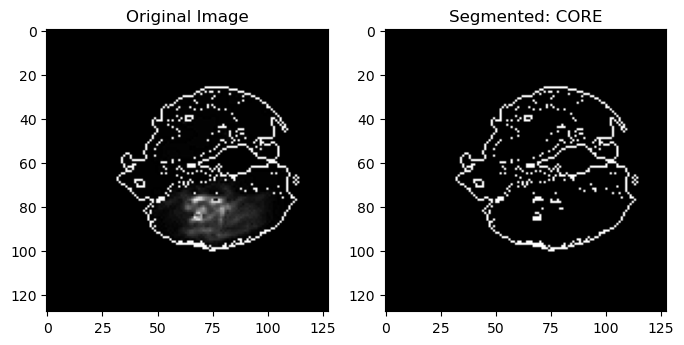

In [5]:
import numpy as np
import cv2
from skimage.filters import gaussian
from scipy.ndimage import convolve
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128
SEGMENT_CLASSES = ["NOT tumor", "ENHANCING", "CORE", "WHOLE"]

def anisotropic_diffusion_filter(img, alpha=0.1, beta=0.1, iterations=2):
    img_filtered = img.astype(np.float64)  # Convert to float64 for calculations
    for _ in range(iterations):
        grad = gaussian(img_filtered, sigma=beta)
        img_filtered += alpha * grad
    img_filtered = np.clip(img_filtered, 0, 255)  # Ensure values are within valid range
    return img_filtered.astype(np.uint8)  # Convert back to uint8


def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharpened = convolve(img, kernel)
    return img_sharpened

# PSO and Segmentation Functions
def objective_function(positions, pixels, gamma, m, n):
    positions = positions.reshape(-1, 1)
    K = lambda x, y: np.exp(-np.linalg.norm(x - y))  # Gaussian kernel
    q, c = len(pixels), len(positions)
    u_kl = np.zeros((c, q))
    t_kl = np.zeros((c, q))
    psi_k = np.zeros(c)

    for k in range(c):
        for l in range(q):
            t_kl[k, l] = ((1 + gamma[l] * psi_k[k] * (1 - K(pixels[l], positions[k]))) ** (1 / (n - 1))) ** -1
            u_kl[k, l] = 1 / np.sum([(
                gamma[l] * t_kl[j, l] ** n * (1 - K(pixels[l], positions[j])) +
                psi_k[j] * (1 - t_kl[j, l]) ** n
            ) ** (1 / (m - 1)) for j in range(c)])
        psi_k[k] = np.sum([
            u_kl[k, l] ** m * t_kl[k, l] ** n * (2 - 2 * K(pixels[l], positions[k])) for l in range(q)
        ]) / np.sum([u_kl[k, l] ** m * t_kl[k, l] ** n for l in range(q)])

    J_m = np.sum([
        gamma[l] * u_kl[k, l] ** m * t_kl[k, l] ** n * (1 - K(pixels[l], positions[k])) +
        psi_k[k] * u_kl[k, l] * (1 - t_kl[k, l]) ** n
        for k in range(c) for l in range(q)
    ])
    return J_m

def perform_pso_optimization(pixels, num_centroids, num_particles, gamma, m, n):
    lower_bound = np.zeros(num_centroids)
    upper_bound = np.ones(num_centroids) * 255
    result, _ = pso(objective_function, lower_bound, upper_bound, args=(pixels, gamma, m, n), swarmsize=num_particles, maxiter=2)
    return result.reshape(-1, 1)

def perform_image_segmentation(image, num_clusters, num_particles, gamma, m, n):
    pixels = image.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    pixels = scaler.fit_transform(pixels)
    centroids = perform_pso_optimization(pixels, num_clusters, num_particles, gamma, m, n)
    labels = KMeans(n_clusters=num_clusters, init=centroids, n_init=1).fit_predict(pixels)
    segmented_image = centroids[labels].reshape(image.shape)
    segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min() + 1e-5)
    segmented_image_rescaled = img_as_ubyte(segmented_image)
    return segmented_image_rescaled.astype(np.uint8)

# Main Function
def segment_single_image(image_path, eval_class=2):
    # Load and preprocess image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = anisotropic_diffusion_filter(image)
    image = sharpen_image(image)

    # Generate random gamma values for PSO
    gamma = np.random.rand(image.size)

    # Perform segmentation
    segmented_image = perform_image_segmentation(
        image, 
        num_clusters=3, 
        num_particles=20, 
        gamma=gamma, 
        m=2, 
        n=2
    )

    # Display
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap="gray")
    plt.title(f"Segmented: {SEGMENT_CLASSES[eval_class]}")

    plt.show()

# Example usage
image_path = "D:/archive/New folder (2)/3.png"  # Update with your image path
segment_single_image(image_path)
